# Newsguard description

In [85]:
from os.path import join
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer
#plt.style.use("apa.mplstyle") #custom matplotlib style

In [2]:
folder_path = "/data/NewsGuard/full-metadata/"
figures_path = "/home/jluehring/newsguard/newsguard-review-paper/figures/"
tables_path = "/home/jluehring/newsguard/newsguard-review-paper/tables/"

## Reading CSV files

In [3]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

In [4]:
df_total = pd.DataFrame()
for csv in csv_files: #taking all files in the folder
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    # taking name of file, removing the extension and "metadata-"
    df["file_date"]=csv.split(".")[0].split("-")[1]
    # converting file_date to datetime, with format YYYYMMDD00
    df["file_date"]=pd.to_datetime(df["file_date"], format="%Y%m%d%H")
    df_total = pd.concat([df_total, df], axis=0)

In [5]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('1501.csv')] #taking only mid-month 
df15 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], format="%Y%m%d%H")
    df15 = pd.concat([df15, df], axis=0)

In [6]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('0201.csv')] #taking only beginning of month
df02 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], format="%Y%m%d%H")
    df02 = pd.concat([df02, df], axis=0)

## Domains

In [7]:
counts_15 = df15.groupby(df15.file_date)\
    .size()\
    .reset_index(name="Counts")
counts_15.head(3)

file_date  Counts
0 2019-03-15 01:00:00    2647
1 2019-04-15 01:00:00    2704
2 2019-05-15 01:00:00    3047

In [8]:
counts_02 = df02.groupby(df02.file_date)\
    .size()\
    .reset_index(name="Counts")

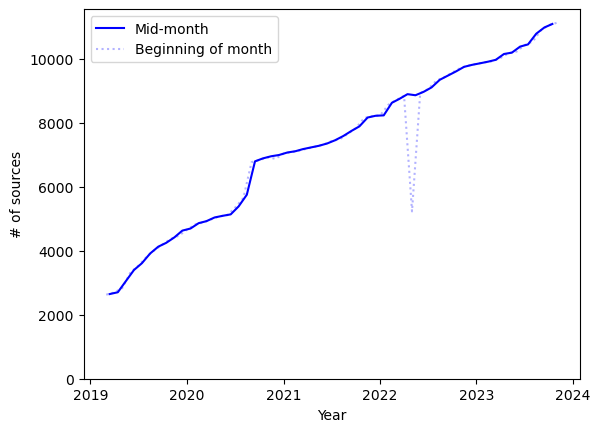

In [9]:
plt.plot(counts_15["file_date"], 
         counts_15["Counts"], 
         color="blue",
         label="Mid-month")
plt.plot(counts_02["file_date"], 
         counts_02["Counts"], 
         color="blue", 
         label="Beginning of month", 
         alpha=0.3, 
         linestyle="dotted")
plt.ylim(0)
plt.xlabel("Year")
plt.ylabel("# of sources")
#plt.xticks(rotation=20)
plt.legend()
plt.savefig(join(figures_path,"f1-sources_over_time.png"), dpi=300)
plt.show()

In [10]:
most_recent = df15[df15["file_date"] == df15["file_date"].max()]
first = df15[df15["file_date"] == df15["file_date"].min()]
print(f'In the most recent file, there are {len(most_recent)} entries, with {most_recent["UUID"].nunique()} rating IDs and {most_recent["Domain"].nunique()} domains.')
print(f'In the first file, there are {len(first)} entries, with {first["UUID"].nunique()} IDs and {first["Domain"].nunique()} domains.')

In the most recent file, there are 11093 entries, with 6474 rating IDs and 9734 domains.
In the first file, there are 2647 entries, with 2647 IDs and 2641 domains.


In [11]:
print(f'The number of entries has grown by {round((len(most_recent)/len(first)-1)*100,2)}%')

The number of entries has grown by 319.08%


In [12]:
rating_counts = most_recent.Rating.value_counts(normalize=False)\
    .reset_index()\
    .rename(columns={"index":"Rating", "Rating":"Count"})

rating_countsp = most_recent.Rating.value_counts(normalize=True)\
    .reset_index()\
    .rename(columns={"index":"Rating", "Rating":"Percent"})

ratings = pd.merge(rating_counts, rating_countsp, on="Rating")

rating_mean = most_recent.groupby("Rating").Score\
    .mean()\
    .reset_index()\
    .rename(columns={"Score":"Mean"})

pd.merge(ratings, rating_mean, on="Rating")

Rating  Count   Percent       Mean
0      T   6609  0.595781  87.422227
1      N   3904  0.351934  26.012167
2     FL    454  0.040927        NaN
3      P     63  0.005679        NaN
4      S     63  0.005679        NaN

In [13]:
most_recent[most_recent.Rating == "P"].Domain.unique()[:3]

array(['odysee.com', 'bitchute.com', 'vimeo.com'], dtype=object)

In [14]:
most_recent[most_recent.Rating == "FL"].Domain.unique()[:3]

array(['govietnamtravel.asia', 'odishadiscoms.com',
       'celebritiesmoney.com'], dtype=object)

In [15]:
p_rating = most_recent[most_recent["Rating"] == "P"]
if not p_rating["Score"].isnull().all():
    mean_score = p_rating["Score"].mean(skipna=True)
    print(f"Mean score for rating P: {mean_score}")
else:
    print(f"No scores available for rating P.")

No scores available for rating P.


The categories S, P, and FL refer to Platforms, as well as Satire and Lifestyle outlets, respectively. They also don't have a trustworthiness score. How many domains are rated in the first and the most recent dataframe?

In [16]:
print(f'In the most recent df, there are {len(most_recent[most_recent["Score"].notnull()])} rated domains while there are {len(first[first["Score"].notnull()])} in the first version of the database.')

#subset the data to only include the domains that have a score
#rated_domains = most_recent[most_recent["Score"].notnull()]

In the most recent df, there are 10513 rated domains while there are 2615 in the first version of the database.


## Trustworthiness

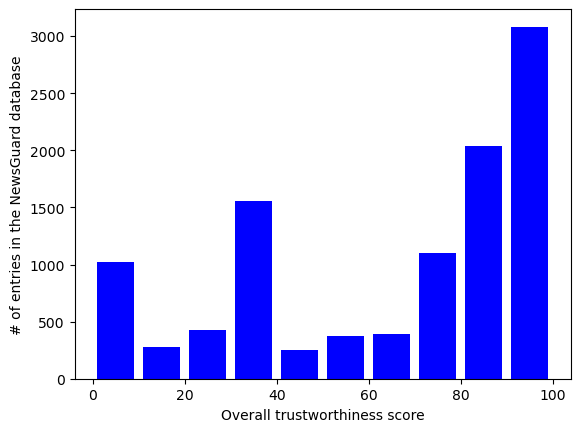

In [17]:
most_recent["Score"].hist(bins=10, 
                          color="blue", 
                          rwidth=0.8, 
                          grid=False)
plt.xlabel("Overall trustworthiness score")
plt.ylabel("# of entries in the NewsGuard database")
plt.savefig(join(figures_path,"f2-trustworthiness_distribution.png"), 
            dpi=300)
plt.show()

In [18]:
df15["file_year"] = pd.to_datetime(df15.file_date)\
    .dt.to_period("Y")
df15["file_month"] = pd.to_datetime(df15.file_date)\
    .dt.to_period("M")
df15.groupby("file_year").Score.value_counts()

file_year  Score
2019       100.0    9525
           87.5     3987
           95.0     2674
           82.5     2606
           5.0      2605
                    ... 
2023       72.0       30
           45.0       20
           67.0       17
           52.5       10
           27.0        8
Name: Score, Length: 303, dtype: int64

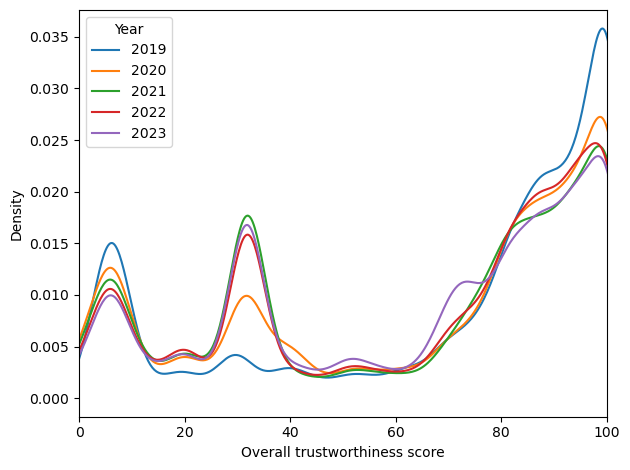

In [19]:
# trustworthiness over time
for date in df15.file_year.unique():
    df15[df15.file_year ==date].Score.plot.kde(
        xlim=(0,100), label=date.strftime("%Y"), bw_method=0.1)
plt.xlabel("Overall trustworthiness score")
plt.ylabel("Density")
plt.legend(title="Year")
plt.tight_layout()
plt.savefig(join(figures_path, "score_distribution_per_year.png"), dpi=300)
plt.show()

In [20]:
year_scores = df15.groupby("file_year")["Score"]\
    .agg(['mean', 'std', 'min', 'max'])\
    .reset_index()
print(year_scores)

  file_year       mean        std  min    max
0      2019  71.767972  33.287474  0.0  100.0
1      2020  66.001125  34.087030  0.0  100.0
2      2021  63.692641  33.858325  0.0  100.0
3      2022  65.200969  33.158941  0.0  100.0
4      2023  64.541012  32.437099  0.0  100.0


In [21]:
month_scores = df15.groupby("file_month")["Score"]\
    .agg(['mean', 'std', 'min', 'max'])\
    .reset_index()
#print first and last entry
print(month_scores.head(1))
print(month_scores.tail(1))

  file_month       mean        std  min    max
0    2019-03  70.786424  35.328616  0.0  100.0
   file_month       mean        std  min    max
54    2023-10  64.617616  32.331231  0.0  100.0


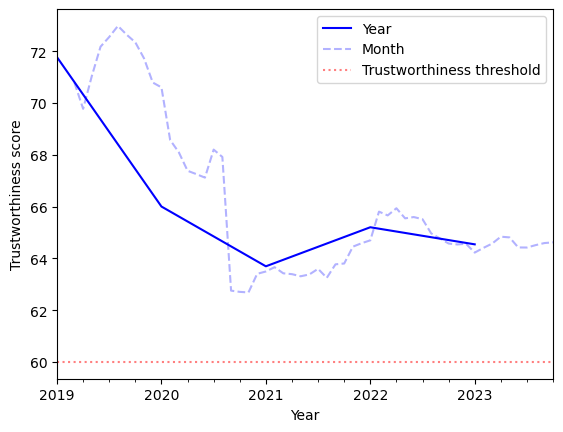

In [22]:
df15.groupby(df15.file_year).Score.mean().plot(color="blue", label="Year")
df15.groupby(df15.file_month).Score.mean().plot(color="blue", label="Month",
                alpha=0.3, linestyle="--")
plt.xlabel("Year")
plt.ylabel("Trustworthiness score")
plt.axhline(y=60, color= "red", linestyle="dotted", 
            alpha=0.5, label="Trustworthiness threshold")
plt.legend()
plt.savefig(join(figures_path,"f3-scores_over_time.png"), dpi=300)
plt.show()

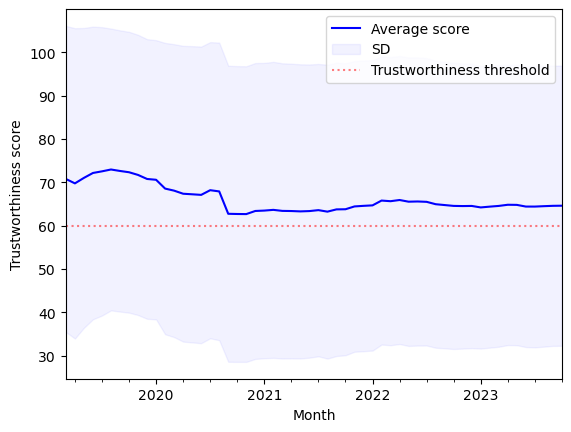

In [23]:
df15.groupby(df15.file_month).Score.mean().plot(color="blue", label="Average score")
plt.fill_between(df15.groupby(df15.file_month).Score.mean().index, 
                 df15.groupby(df15.file_month).Score.mean() - df15.groupby(df15.file_month).Score.std(), 
                 df15.groupby(df15.file_month).Score.mean() + df15.groupby(df15.file_month).Score.std(), 
                 color="blue", alpha=0.05, label="SD")
plt.xlabel("Month")
plt.ylabel("Trustworthiness score")
plt.axhline(y=60, color= "red", linestyle="dotted", 
            alpha=0.5, label="Trustworthiness threshold")
plt.legend()

## Added and removed sources

In [24]:
domain_changes = {}
unique_months = df15.sort_values("file_date")["file_date"]\
                    .unique()

for i in range(1, len(unique_months)):
    current_month = unique_months[i]
    previous_month = unique_months[i - 1]
    
    added_month = set(df15[df15["file_date"] == current_month]["Domain"].tolist())\
        - set(df15[df15["file_date"] == previous_month]["Domain"].tolist())
    removed_month = set(df15[df15["file_date"] == previous_month]["Domain"].tolist())\
        - set(df15[df15["file_date"] == current_month]["Domain"].tolist())
    domain_changes[current_month] = added_month, removed_month

In [25]:
domain_list_added = []
domain_list_removed = []
for date in domain_changes.keys():
    domain_list_added.extend(domain_changes[date][0])
    domain_list_removed.extend(domain_changes[date][1])

print(f"Total number of added sources: {len(domain_list_added)}")
print(f"Total number of removed sources: {len(domain_list_removed)}")

Total number of added sources: 7705
Total number of removed sources: 612


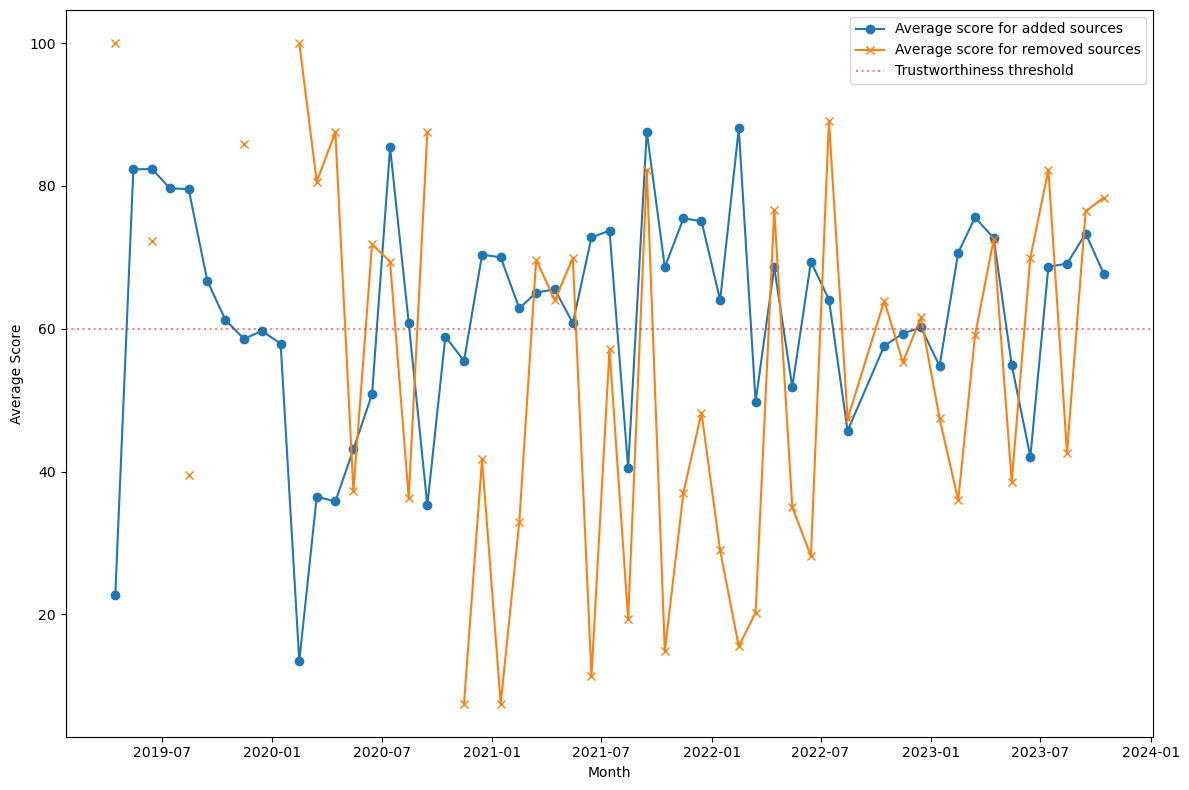

In [26]:
added_scores = []
removed_scores = []
months = []

for date in domain_changes.keys():
    added_sources = df15[df15.Domain.isin(domain_changes[date][0])]
    removed_sources = df15[df15.Domain.isin(domain_changes[date][1])]

    added_mean = added_sources["Score"].mean()
    removed_mean = removed_sources["Score"].mean()
    added_scores.append(added_mean)
    removed_scores.append(removed_mean)
    months.append(date)

plt.figure(figsize=(12, 8))
plt.plot(months, added_scores, 
         marker='o', 
         label='Average score for added sources')
plt.plot(months, removed_scores, 
         marker='x', 
         label='Average score for removed sources')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.axhline(y=60, 
            color= "red", 
            linestyle="dotted", 
            alpha=0.5, 
            label="Trustworthiness threshold")
plt.xticks()
plt.legend()
plt.tight_layout()

In [27]:
added_mean = df15[df15.Domain.isin(domain_list_added)]["Score"].mean()
removed_mean = df15[df15.Domain.isin(domain_list_removed)]["Score"].mean()
added_std = df15[df15.Domain.isin(domain_list_added)]["Score"].std()
removed_std = df15[df15.Domain.isin(domain_list_removed)]["Score"].std()
print(f"Overall mean for added sources: {added_mean}, SD: {added_std}.")
print(f"Overall mean for removed sources: {removed_mean}, SD: {removed_std}.")

Overall mean for added sources: 62.08914091239942, SD: 32.14377351763479.
Overall mean for removed sources: 53.49675250248338, SD: 31.59847336786034.


## Last Updated

In [28]:
df15["Last Updated"]=pd.to_datetime(df15["Last Updated"],unit="ms")
df15["Last Updated"].head(3)

0   2018-07-20 14:03:17.020
1   2018-07-20 14:03:21.115
2   2018-07-20 14:03:25.883
Name: Last Updated, dtype: datetime64[ns]

In [29]:
df15_UUID = df15.drop_duplicates(subset="UUID", 
                                 keep="first")
print(f'Without UUID length = {len(df15)}, with UUID = {len(df15_UUID)}.')

Without UUID length = 399389, with UUID = 44611.


In [30]:
domain_updates_sorted = df15_UUID.groupby("Domain").apply( #group by domain
                        lambda x: x.sort_values("Last Updated") #then sort by last updated
                        ).reset_index(drop=True) #reset index

domain_updates_sorted.head(3)

UUID         Domain        Parent Domain  \
0  b9704871-32df-4721-881c-2dc6d03d8905  1000logos.net                  NaN   
1  07be0795-9c5e-43ad-932b-e7e0154d5828   100fedup.com  100percentfedup.com   
2  a7cfbf89-68cf-4a16-9b92-96cbda6cdad5   100fedup.com  100percentfedup.com   

  Rating  Score            Last Updated Country Language  \
0     FL    NaN 2023-09-27 04:25:20.721      US       en   
1      N    7.5 2018-09-08 22:26:33.205      US       en   
2      N    7.5 2019-10-04 23:22:52.632      US       en   

  Does not repeatedly publish false content  \
0                                       NaN   
1                                        No   
2                                        No   

  Gathers and presents information responsibly  ... LINKEDIN IOSAPP  \
0                                          NaN  ...      NaN    NaN   
1                                           No  ...      NaN    NaN   
2                                           No  ...      NaN    NaN   

  ANDROIDAPP OTHER Contact Mail Form URL.1 Communities Served  \
0        NaN   NaN                     NaN                NaN   
1        NaN   NaN                     NaN                NaN   
2        NaN   NaN                     NaN                NaN   

  BrandGuard Segments False Narratives file_year file_month  
0                 NaN              NaN      2023    2023-10  
1                 NaN              NaN      2019    2019-03  
2                 NaN              NaN      2019    2019-10  

[3 rows x 65 columns]

In [31]:
domain_updates_diff = domain_updates_sorted.groupby("Domain")["Last Updated"]\
                                            .diff()

In [32]:
mean_diff_per_domain = domain_updates_diff.groupby(domain_updates_sorted["Domain"])\
                                            .mean()
print(mean_diff_per_domain)

Domain
1000logos.net                                  NaT
100fedup.com              242 days 20:33:44.148500
100giornidaleoni.it    121 days 23:40:35.276333334
100milefreepress.net                           NaT
100percentfedup.com    261 days 09:45:57.592285716
                                   ...            
zonazealots.com           420 days 05:06:58.393000
zt.20minut.ua                                  NaT
zuerst.de              140 days 00:42:35.585571428
zurzeit.at                  0 days 00:00:01.480000
zvw.de                    174 days 13:53:17.657400
Name: Last Updated, Length: 10168, dtype: timedelta64[ns]


In [33]:
print(f'The average time difference between updates is: {mean_diff_per_domain.mean()} days, SD={mean_diff_per_domain.std()}.')
print(f'The range of time differences between updates is: max={mean_diff_per_domain.max()}, min={mean_diff_per_domain.min()} days.')

The average time difference between updates is: 279 days 11:02:28.298169388 days, SD=126 days 23:57:42.207242418.
The range of time differences between updates is: max=1109 days 19:36:32.340000, min=0 days 00:00:00.986000 days.


In [34]:
mean_diff_per_domain.describe()

count                           8601
mean     279 days 11:02:28.298169388
std      126 days 23:57:42.207242418
min           0 days 00:00:00.986000
25%      186 days 15:18:13.930666666
50%         288 days 23:37:51.581000
75%         389 days 07:35:13.919500
max        1109 days 19:36:32.340000
Name: Last Updated, dtype: object

In [35]:
print(mean_diff_per_domain[mean_diff_per_domain == mean_diff_per_domain.max()])
print(mean_diff_per_domain[mean_diff_per_domain == mean_diff_per_domain.min()])

Domain
eblida.org   1109 days 19:36:32.340000
Name: Last Updated, dtype: timedelta64[ns]
Domain
general-anzeiger-bonn.de   0 days 00:00:00.986000
Name: Last Updated, dtype: timedelta64[ns]


In [36]:
domain_updates_sorted["Score_diff"] = domain_updates_sorted\
                                        .groupby("Domain")["Score"]\
                                        .diff()
domain_score_diff = domain_updates_sorted\
                            .groupby("Domain")["Score_diff"]\
                            .mean()
print(f'The average score difference between updates is: {domain_score_diff.mean()}, 
        SD={domain_score_diff.std()}.')
print(f'The range of score differences is: max={domain_score_diff.max()}, 
      min={domain_score_diff.min()}')

The average score difference between updates is: -0.39525259941762675, SD=4.118787190792775.
The range of score differences is: max=62.5, min=-34.5


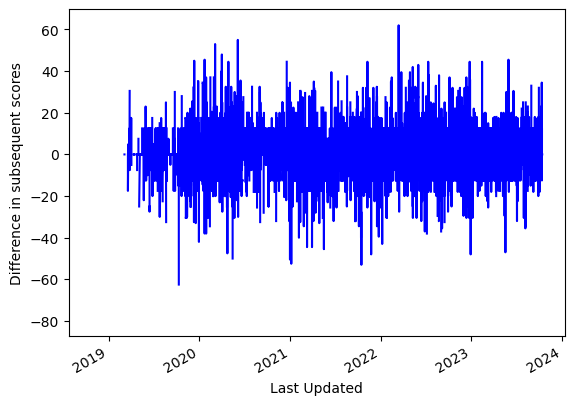

In [37]:
domain_updates_sorted.groupby(domain_updates_sorted["Last Updated"]).Score_diff\
                        .mean()\
                        .plot(color="blue")
plt.ylabel("Difference in subsequent scores")
plt.xlabel("Last Updated")

plt.savefig(join(figures_path, "f4-score_updates.png"), 
            dpi=300)
plt.show()

/tmp/ipykernel_753005/4276977480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df15_UUID["last_updated_month"] = pd.to_datetime(df15_UUID["Last Updated"])\


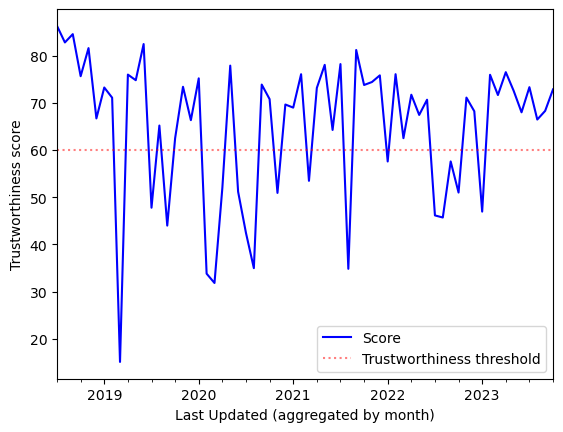

In [38]:
df15_UUID["last_updated_month"] = pd.to_datetime(df15_UUID["Last Updated"])\
                                .dt.to_period("M")
df15_UUID.groupby(df15_UUID.last_updated_month).Score\
    .mean()\
    .plot(color="blue", 
          label="Score")
plt.xlabel("Last Updated (aggregated by month)")
plt.ylabel("Trustworthiness score")
plt.axhline(y=60, color="red", 
            linestyle="dotted", 
            alpha=0.5, 
            label="Trustworthiness threshold")
plt.savefig(join(figures_path, "average_score_per_update.png"), dpi=300)
plt.legend()
plt.show()

In [39]:
domain_updates_sorted.sort_values("Score_diff", ascending=True)\
                                [["Domain", "Score_diff", "Last Updated"]]\
                        .head(5)

Domain  Score_diff            Last Updated
7079   conservativedailynews.com       -80.0 2020-11-23 21:39:32.187
37650          thefederalist.com       -62.5 2019-10-10 17:21:38.137
38273       theragingpatriot.com       -53.0 2021-10-15 12:19:44.207
38164            theohiostar.com       -52.5 2021-01-05 22:53:34.221
29611              pluralist.com       -50.5 2020-12-31 18:12:44.411

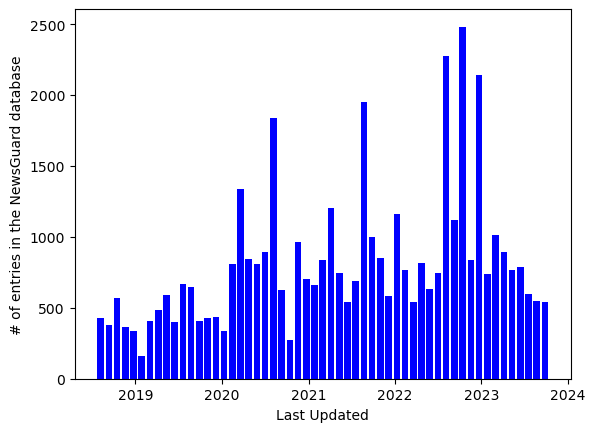

In [40]:
df15_UUID["Last Updated"].hist(bins=df15_UUID["file_date"].nunique(), 
                               color="blue", 
                               rwidth=0.8,
                               grid=False)
plt.xlabel("Last Updated")
plt.ylabel("# of entries in the NewsGuard database")
#plt.savefig(join(figures_path, "last_updated_distribution.png"), dpi=300)
plt.show()

## Countries

In [41]:
table1 = df15.groupby(["Country", "Language"]).agg(
    n=("Domain", "nunique")
).reset_index()

table1.columns = ["Country", "Language", "n"]
table1["%"] = (table1["n"] / df15["Domain"].nunique() * 100).round(2)

table1

Country Language     n      %
0      ALL       en  1442  14.00
1       AT       de    39   0.38
2       AU       en   131   1.27
3       CA       en   414   4.02
4       CA       fr    45   0.44
5       DE       de   370   3.59
6       FR       fr   430   4.18
7       GB       en   619   6.01
8       IT       it   524   5.09
9       NZ       en    18   0.17
10      US       en  7803  75.77
11      US       es     1   0.01

In [42]:
#save table as latex >turn into function for later tables?
table1_latex = table1.sort_values("n", ascending=False).to_latex(
    index=False, escape=False,
    caption="\\textbf{Country Descriptives.}",
    label="table:table1", position='H',
    column_format=' X c c c ',
    longtable=False, header=True, na_rep='---', 
    bold_rows=True)

table1_latex = table1_latex.replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
table1_latex = table1_latex.replace("\\end{tabular}", "\\end{tabularx}")

table1_latex = table1_latex.replace("\\bottomrule", "\\bottomrule\n\\textit{Note.} We counted unique domains across all versions of the database.")

with open(join(tables_path, "t1_countries.tex"), 'w') as f:
    f.write(table1_latex)

/tmp/ipykernel_753005/3941157121.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table1_latex = table1.sort_values("n", ascending=False).to_latex(


In [43]:
table2 = df15.groupby(["Country", "file_date"]).agg(
    {"Score": ["mean", "std"]}).reset_index()
table2.columns = ["Country", "file_date", "Score_mean", "Score_std"]
table2 = table2.groupby("Country").agg(
    {"Score_mean": "mean", "Score_std": "mean"}).reset_index()

In [44]:
table2["Score_mean"] = table2["Score_mean"].round(2)
table2["Score_std"] = table2["Score_std"].round(2)
table2['Mean (SD)'] = table2.apply(lambda row: f'{row["Score_mean"]} ({row["Score_std"]})', axis=1)
table2 = table2.drop(["Score_mean", "Score_std"], axis=1)

table2_latex = table2.sort_values("Mean (SD)", ascending=False).to_latex(
    index=False, escape=False,
    caption="\\textbf{Average trustworthiness score per country.}",
    label="table:table2", position='H',
    column_format=' X c ',
    longtable=False, header=True, na_rep='---', 
    bold_rows=True)

table2_latex = table2_latex.replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
table2_latex = table2_latex.replace("\\end{tabular}", "\\end{tabularx}")

table2_latex = table2_latex.replace("\\bottomrule", "\\bottomrule\n\\textit{Note.} Aggregated per month.")

with open(join(tables_path, "t2_scores.tex"), 'w') as f:
    f.write(table2_latex)

/tmp/ipykernel_753005/896685402.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table2_latex = table2.sort_values("Mean (SD)", ascending=False).to_latex(


In [45]:
language_score = df15.groupby(["Language", "file_date"]).agg(
    {"Score": "mean"}).reset_index()
language_score.groupby("Language").Score\
                .mean()\
                .sort_values(ascending=False)

Language
es    82.500000
de    78.034553
it    73.128907
fr    66.917199
en    65.301883
Name: Score, dtype: float64

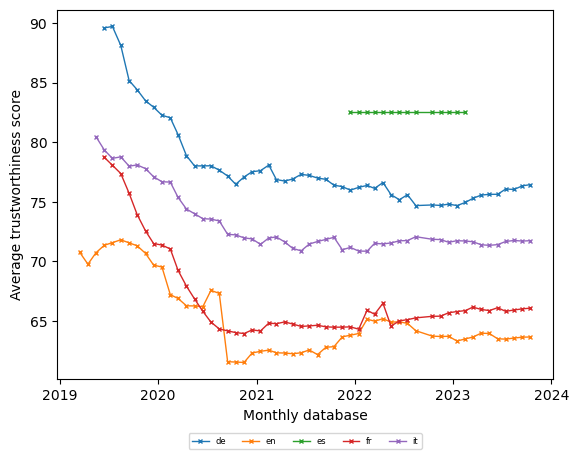

In [46]:
for language in language_score["Language"].unique():
    language_df = language_score[language_score["Language"] == language]
    plt.plot(language_df["file_date"], language_df["Score"], 
             label=language,
             marker="x", 
             linewidth=1, 
             markersize=3)

plt.xlabel("Monthly database")
plt.ylabel("Average trustworthiness score")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), 
           ncol=len(language_score), fontsize=6)
plt.show()

In [47]:
country_score = df15.groupby(["Country","file_date"]).agg(
    {"Score": "mean"}).reset_index()

country_score.groupby("Country").Score\
                .mean()\
                .sort_values(ascending=False)

Country
CA     86.358414
NZ     81.809299
GB     79.584535
DE     78.123270
IT     73.128907
ALL    72.477104
AT     71.930647
AU     71.253434
FR     66.520620
US     62.466285
Name: Score, dtype: float64

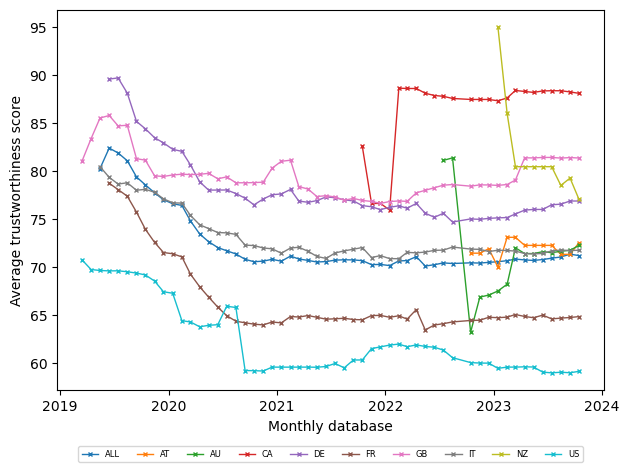

In [48]:
for country in country_score["Country"].unique():
    country_df = country_score[country_score["Country"] == country]
    plt.plot(country_df["file_date"], country_df["Score"], 
             label=country,
             marker="x",
             linewidth=1,
             markersize=3)

plt.xlabel("Monthly database")
plt.ylabel("Average trustworthiness score")
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=len(country_score), 
           fontsize=6)
plt.tight_layout()

plt.savefig(join(figures_path,"scores_over_time_per_country.png"), 
            dpi=300)

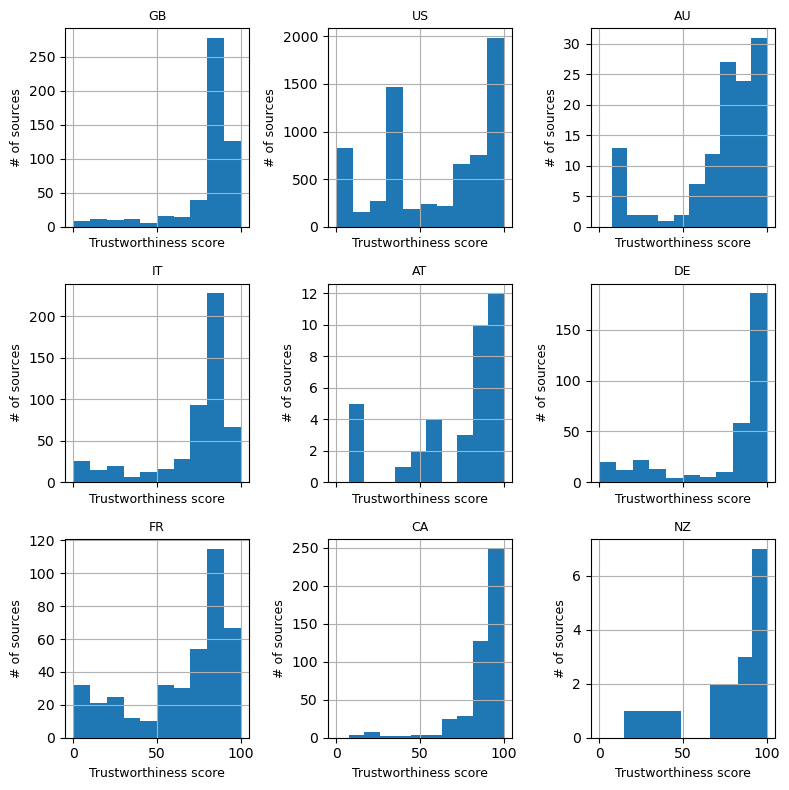

In [49]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
country_df = most_recent[most_recent["Country"] != "ALL"]

for i, country in enumerate(country_df["Country"].unique()):
    row = i // 3 
    col_in_row = i % 3  
    df = country_df[country_df["Country"] == country]
    df["Score"].hist(ax=axs[row, col_in_row])
    axs[row, col_in_row].set_xlabel("Trustworthiness score", fontsize=9)
    axs[row, col_in_row].set_ylabel("# of sources", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)

plt.tight_layout()

plt.savefig(join(figures_path,"scores_per_country_recent.png"), dpi=300)
plt.show()

In [50]:
#do the same with the number of domains over time
country_domains = df15.groupby(["Country","file_date"]).agg(
    {"Domain": "nunique"}).reset_index()

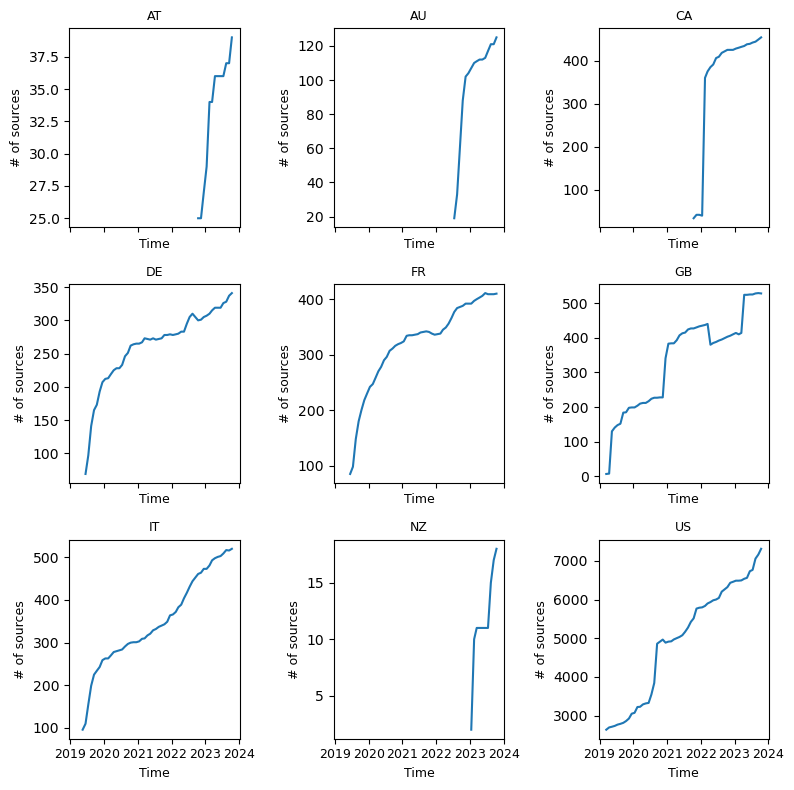

In [51]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

filtered_countries = country_domains[country_domains["Country"] != "ALL"]["Country"].unique()

for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_domains[country_domains["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Domain"], label=country)
    axs[row, col_in_row].set_xlabel("Time", fontsize=9)
    axs[row, col_in_row].set_ylabel("# of sources", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=9)

plt.tight_layout()
plt.savefig(join(figures_path,"n_country_over_time.png"), dpi=300)
plt.show()

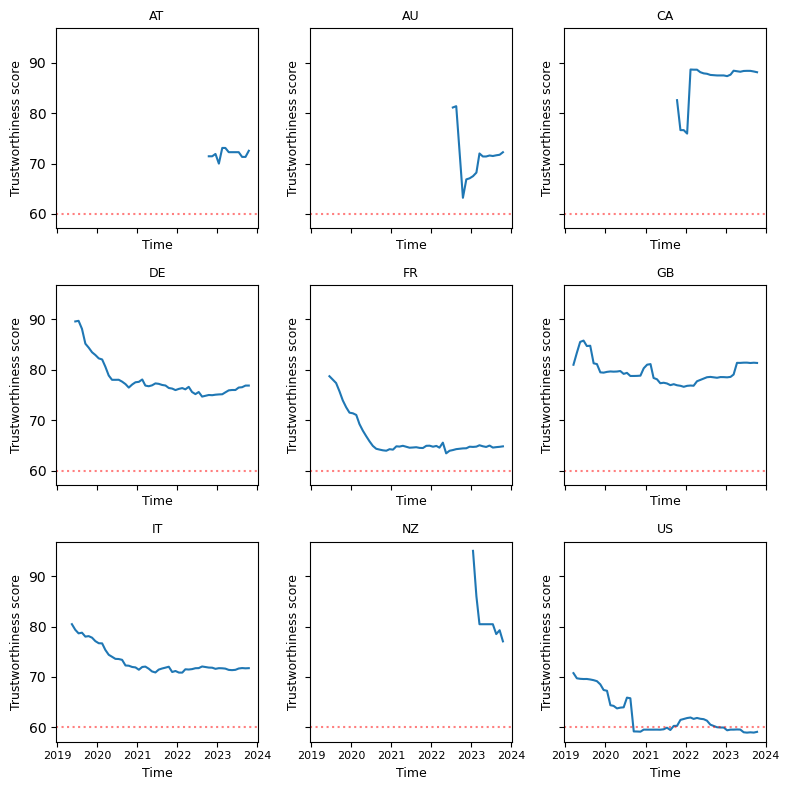

In [52]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_score[country_score["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Score"], 
                              label=country)
    axs[row, col_in_row].set_xlabel("Time", fontsize=9)
    axs[row, col_in_row].set_ylabel("Trustworthiness score", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=8)
    axs[row, col_in_row].axhline(y=60, color="red", linestyle="dotted", 
                                 alpha=0.5, label="Trustworthiness threshold")

plt.tight_layout()
plt.savefig(join(figures_path,"f5-scores_country_over_time.png"), dpi=300)
plt.show()

In [62]:
country_updates_sorted = df15_UUID\
                            [["Country", "Domain", "Last Updated", "Score"]]\
                            .sort_values(
                                by=["Country", "Domain", "Last Updated"])\
                            .reset_index(drop=True)

In [64]:
country_updates_sorted["Time_Diff"] = country_updates_sorted\
                            .groupby(["Country", "Domain"])\
                            ["Last Updated"]\
                            .diff()

country_updates_sorted["Score_Diff"] = country_updates_sorted\
                            .groupby(["Country", "Domain"])\
                            ["Score"]\
                            .diff()
country_updates_sorted.head(3)

Country               Domain            Last Updated  Score  \
0     ALL  100giornidaleoni.it 2022-05-23 10:23:51.210   30.0   
1     ALL  100giornidaleoni.it 2023-05-24 09:25:20.659   30.0   
2     ALL          2020news.de 2021-04-20 12:24:13.398   20.0   

                 Time_Diff  Score_Diff  
0                      NaT         NaN  
1 365 days 23:01:29.449000         0.0  
2                      NaT         NaN

In [67]:
time_diff_per_domain = country_updates_sorted\
                                    .groupby(["Country", "Domain"])["Time_Diff"]\
                                    .mean()\
                                    .reset_index()

time_diff_per_domain.groupby("Country")["Time_Diff"]\
                        .mean()\
                        .reset_index()

Country                   Time_Diff
0     ALL 372 days 23:23:56.758474492
1      AT    222 days 03:36:09.143500
2      AU 285 days 20:38:39.140598684
3      CA 370 days 16:22:46.023953648
4      DE 404 days 19:00:36.546530128
5      FR 401 days 05:54:18.890466024
6      GB 313 days 03:24:26.511053680
7      IT 334 days 17:28:13.021875336
8      NZ    221 days 08:45:43.700250
9      US 303 days 08:26:56.399614368

In [68]:
score_diff_per_domain = country_updates_sorted\
                                    .groupby(["Country", "Domain"])["Score_Diff"]\
                                    .mean()\
                                    .reset_index()

score_diff_per_domain.groupby("Country")["Score_Diff"]\
                        .mean()\
                        .reset_index()

Country  Score_Diff
0     ALL    0.389249
1      AT    0.937500
2      AU    0.222603
3      CA    1.771186
4      DE    0.901213
5      FR    0.464433
6      GB   -0.421517
7      IT    0.002550
8      NZ    0.000000
9      US   -0.621476

In [55]:
country_updates = df15_UUID\
                    .groupby("Country")["Last Updated"]\
                    .describe(#datetime_is_numeric=True
                    )\
                    .sort_values("count", ascending=False)
country_updates

/tmp/ipykernel_753005/2515929946.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df15_UUID\
/tmp/ipykernel_753005/2515929946.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df15_UUID\
/tmp/ipykernel_753005/2515929946.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df15_UUID\
/tmp/ipykernel_753005/2515929946.py:1: FutureWarn

count unique                         top freq  \
Country                                                  
US       32076  32062  2023-03-28 10:21:35.845000    4   
ALL       4800   4800  2019-05-14 20:21:53.352000    1   
IT        1966   1966  2019-05-14 17:50:33.254000    1   
GB        1914   1913  2022-06-14 17:09:45.681000    2   
FR        1505   1505  2019-06-04 14:29:49.782000    1   
DE        1228   1228  2019-05-21 18:50:58.431000    1   
CA         841    841  2021-09-29 18:03:26.677000    1   
AU         216    216  2022-07-08 10:00:38.600000    1   
AT          43     43  2022-08-25 05:39:16.089000    1   
NZ          22     22  2023-01-09 16:53:12.474000    1   

                              first                        last  
Country                                                          
US       2018-07-20 14:03:17.020000  2023-10-13 18:38:26.531000  
ALL      2019-05-13 13:59:57.635000  2023-10-13 07:42:31.010000  
IT       2019-05-13 13:01:34.990000  2023-10-13 07:42:53.664000  
GB       2019-01-22 20:08:15.039000  2023-10-13 20:34:49.278000  
FR       2019-05-22 13:00:05.234000  2023-10-09 18:52:32.154000  
DE       2019-05-21 13:00:27.025000  2023-10-12 08:38:44.239000  
CA       2021-09-28 14:46:52.465000  2023-10-06 19:55:03.397000  
AU       2022-07-01 14:57:02.861000  2023-10-13 18:06:44.735000  
AT       2022-08-24 06:43:10.210000  2023-10-12 09:05:27.686000  
NZ       2023-01-09 14:50:54.347000  2023-09-25 07:22:40.397000

In [56]:
#turn Last Updated into year
df15_UUID["update_year"] = df15_UUID["Last Updated"].dt.year
year_updates = df15_UUID\
                .groupby(["Country", "update_year"])\
                .size()\
                .reset_index(name="Update Count")

year_updates.groupby("Country")["Update Count"]\
            .mean()\
            .sort_values(ascending=False)

/tmp/ipykernel_753005/3504178793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df15_UUID["update_year"] = df15_UUID["Last Updated"].dt.year


Country
US     5346.000000
ALL     960.000000
IT      393.200000
GB      382.800000
FR      301.000000
CA      280.333333
DE      245.600000
AU      108.000000
NZ       22.000000
AT       21.500000
Name: Update Count, dtype: float64

In [69]:
filtered_df = country_updates[~country_updates.index.isin(["US", "ALL"])]
filtered_df["unique"].mean()

966.75

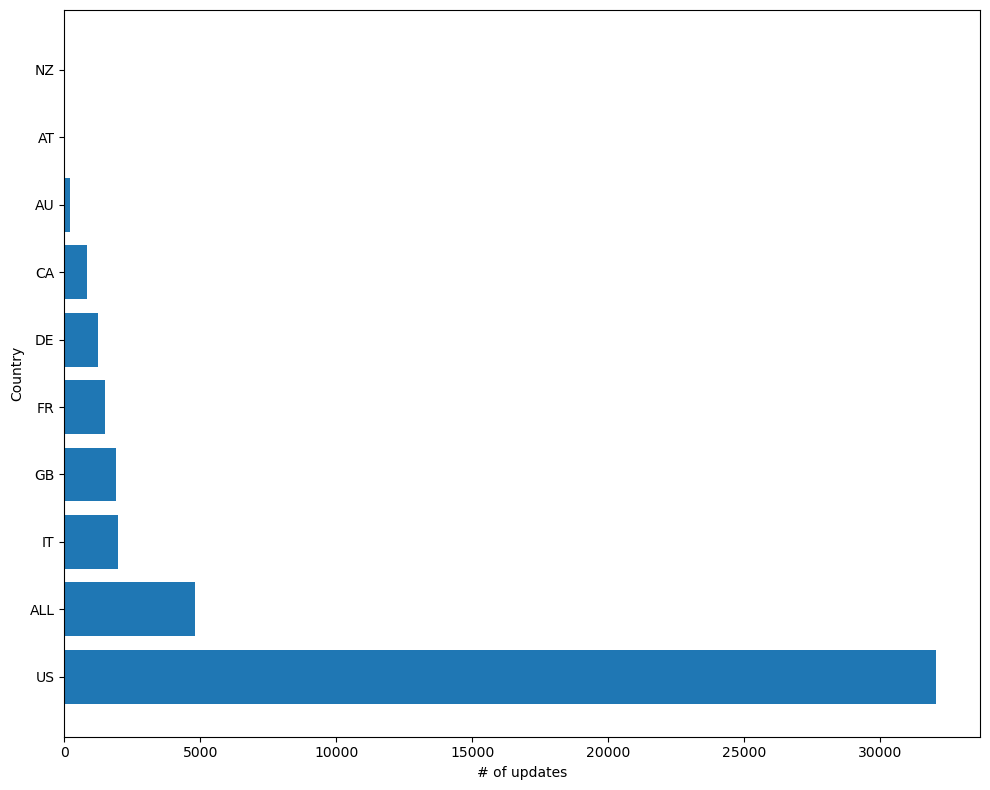

In [70]:
plt.figure(figsize=(10, 8))
country_updates = country_updates.sort_values("unique", ascending=False)
plt.barh(country_updates.index, country_updates["unique"])
plt.xlabel("# of updates") 
plt.ylabel("Country")
plt.tight_layout()
plt.savefig(join(figures_path, "updates_per_country.png"), dpi=300)
plt.show()

In [71]:
unique_updates = df15_UUID.groupby(["Country", "file_year"])["Last Updated"]\
    .nunique().reset_index()
unique_updates.columns = ["Country", "Year", "Updates"]
unique_updates["Year"] = unique_updates["Year"].astype(str)

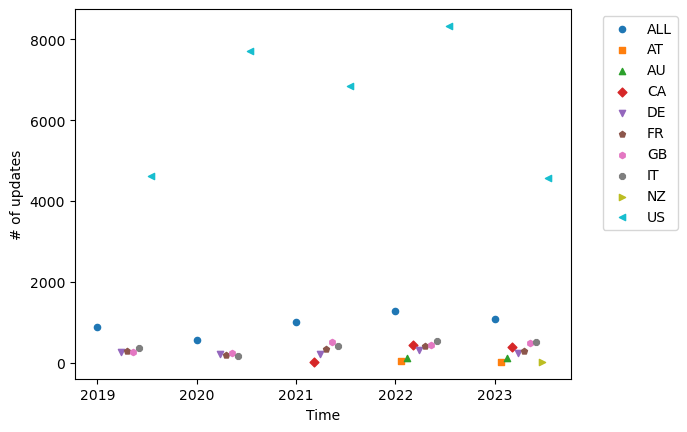

In [72]:
markers = ["o", "s", "^", "D", "v", "p", "h", "8", ">", "<"]
dodge = 0.06
unique_updates["Year"] = pd.to_numeric(unique_updates["Year"], errors="coerce")
for i, country in enumerate(unique_updates["Country"].unique()):
    country_df = unique_updates[unique_updates["Country"] == country]
    plt.scatter(
            country_df["Year"] + i * dodge, 
            country_df["Updates"], label=country, 
            marker=markers[i % len(markers)],  
            s=20)
plt.xlabel("Time")
plt.ylabel("# of updates")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig(join(figures_path, "updates_per_country_over_time.png"), dpi=300)
plt.show()

## Criteria
From the website:
1. Does not repeatedly publish false content: The site does not repeatedly and currently produce content that has been found to be clearly and significantly false, and which has not been quickly and prominently corrected. There is a “high bar” for failing this criterion. In practice, it means that on any given day the website is likely to display significantly false content. (22 Points.)
2. Gathers and presents information responsibly: Content providers are generally fair and accurate in reporting and presenting information. They reference multiple sources, preferably those that present direct, firsthand information on a subject or event or from credible secondhand news sources, and they do not egregiously distort or misrepresent information to make an argument or report on a subject. (18 Points)
3. Regularly corrects or clarifies errors: The site has effective practices for identifying errors and for publishing clarifications and corrections, transparently acknowledges errors, and does not regularly leave significant false content uncorrected. (12.5 Points)
4. Handles the difference between news and opinion responsibly: Content providers who convey the impression that they report news or a mix of news and opinion distinguish opinion from news reporting, and when reporting news, do not egregiously cherry pick facts or stories to advance opinions. Content providers who advance a particular point of view disclose that point of view. (12.5 Points)
5. Avoids deceptive headlines: The site generally does not publish headlines that include false information, significantly sensationalize, or otherwise do not reflect what is actually in the content under the headline. (10 Points)
6. Website discloses ownership and financing: The site discloses in a user-friendly manner its ownership and/or financing, as well as any notable political affiliations or financial interests relevant to the site’s coverage held by those with a significant financial interest in the site. Put simply, the reader should know who is funding the content and what relevant interests the owner or funder might have in the content. (7.5 Points)
7. Clearly labels advertising: The site makes clear which content is paid for and which is not. (7.5 Points)
8. Reveals who’s in charge, including possible conflicts of interest: Those in charge of the content are identified on the site, and there is a way for readers to contact the site about editorial issues. In other words, the reader is told who is in charge of deciding what content is published. (5 Points)
9. The site provides the names of content creators, along with either contact or biographical information: Information about those producing the content is made accessible on the site, and it is generally clear who produces which content. (5 Points) 

In [73]:
most_recent.rename(columns={
    "Reveals who's in charge, including any possible conflicts of interest": 
    "Reveals who's in charge,\n including any possible conflicts of interest", 
    "The site provides names of content creators, along with either contact or biographical information":
    "The site provides names of content creators,\n along with either contact or biographical information"
}, inplace=True)

df15.rename(columns={
    "Reveals who's in charge, including any possible conflicts of interest": 
    "Reveals who's in charge,\n including any possible conflicts of interest", 
    "The site provides names of content creators, along with either contact or biographical information":
    "The site provides names of content creators,\n along with either contact or biographical information"
}, inplace=True)

/tmp/ipykernel_753005/2077108108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_recent.rename(columns={


In [74]:
criteria_columns = most_recent.columns[8:17]
criteria_columns

Index(['Does not repeatedly publish false content',
       'Gathers and presents information responsibly',
       'Regularly corrects or clarifies errors',
       'Handles the difference between news and opinion responsibly',
       'Avoids deceptive headlines',
       'Website discloses ownership and financing',
       'Clearly labels advertising',
       'Reveals who's in charge,\n including any possible conflicts of interest',
       'The site provides names of content creators,\n along with either contact or biographical information'],
      dtype='object')

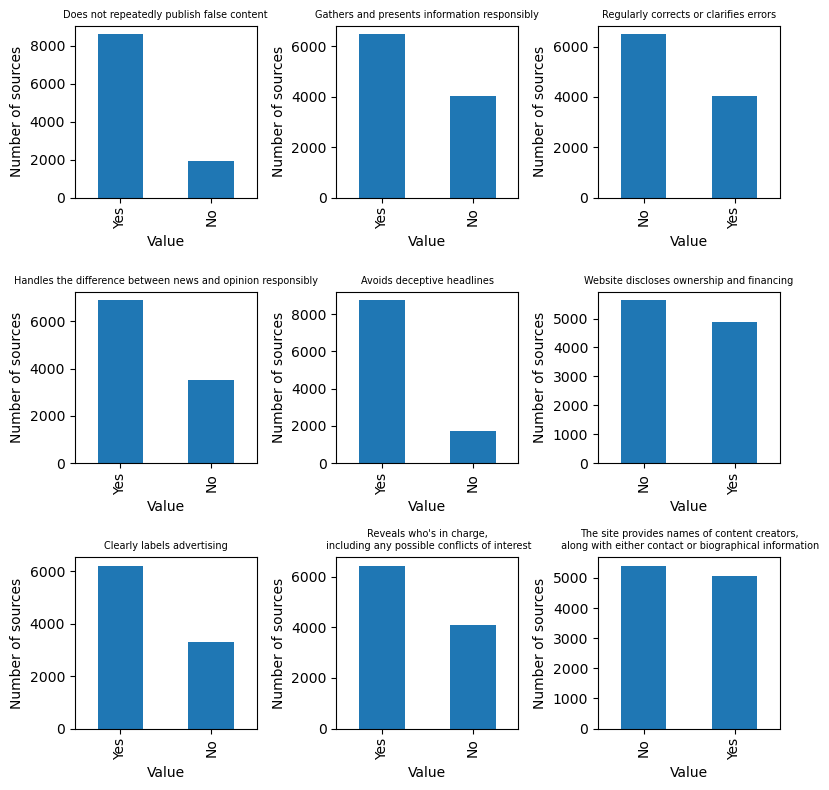

In [75]:
def plot_yesno(columns, most_recent):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

    for i, col in enumerate(columns):
        row = i // 3 
        col_in_row = i % 3  
        most_recent[col].value_counts().plot(kind="bar", 
                                             ax=axs[row, col_in_row])
        axs[row, col_in_row].set_xlabel("Value")
        axs[row, col_in_row].set_ylabel("Number of sources")
        axs[row, col_in_row].set_title(f'{col}', fontsize=7)

    plt.tight_layout()
    plt.show()

plot_yesno(criteria_columns, most_recent)

In [76]:
for col in criteria_columns:
    print(f"{col}: {most_recent[col].value_counts()[0]}")

Does not repeatedly publish false content: 8597
Gathers and presents information responsibly: 6472
Regularly corrects or clarifies errors: 6478
Handles the difference between news and opinion responsibly: 6910
Avoids deceptive headlines: 8754
Website discloses ownership and financing: 5643
Clearly labels advertising: 6212
Reveals who's in charge,
 including any possible conflicts of interest: 6432
The site provides names of content creators,
 along with either contact or biographical information: 5409


In [77]:
for col in criteria_columns:
    print(f"{col}: {most_recent[col].value_counts()[0]/len(most_recent)*100}")

Does not repeatedly publish false content: 77.49932389795366
Gathers and presents information responsibly: 58.34309925178041
Regularly corrects or clarifies errors: 58.39718741548724
Handles the difference between news and opinion responsibly: 62.291535202379876
Avoids deceptive headlines: 78.9146308482827
Website discloses ownership and financing: 50.86991796628505
Clearly labels advertising: 55.99927882448391
Reveals who's in charge,
 including any possible conflicts of interest: 57.98251149373479
The site provides names of content creators,
 along with either contact or biographical information: 48.7604795817182


In [78]:
melted_data = pd.melt(most_recent, value_vars=criteria_columns, 
                      var_name="Criteria", value_name="Label")
reshaped_data = melted_data.groupby(
                        ["Criteria", "Label"]).size().unstack(
                            fill_value=0).reset_index()
reshaped_data

Label                                           Criteria    No   Yes
0                             Avoids deceptive headlines  1746  8754
1                             Clearly labels advertising  3284  6212
2              Does not repeatedly publish false content  1916  8597
3           Gathers and presents information responsibly  4041  6472
4      Handles the difference between news and opinio...  3541  6910
5                 Regularly corrects or clarifies errors  6478  4034
6      Reveals who's in charge,\n including any possi...  4078  6432
7      The site provides names of content creators,\n...  5409  5068
8              Website discloses ownership and financing  5643  4870

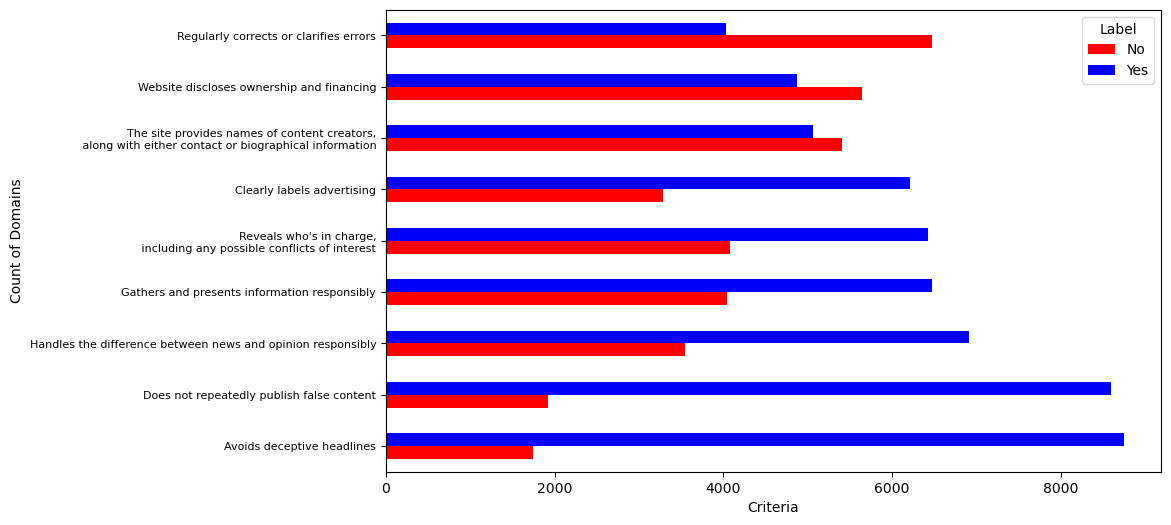

In [79]:
reshaped_data.sort_values("Yes", ascending=False).plot(
    x='Criteria', kind='barh', stacked=False, 
    color=['red', 'blue'], figsize=(10, 6))
plt.xlabel('Criteria')
plt.ylabel('Count of Domains')
plt.yticks(fontsize=8)
plt.legend(title='Label', loc='upper right')
plt.show()

In [80]:
df15 = df15.replace("Yes", 1)
df15 = df15.replace("No", 0)
criteria_df = df15[criteria_columns]
criteria_df = criteria_df.fillna(0) 
cooccurrence = criteria_df.T.dot(criteria_df)
cooccurrence

Does not repeatedly publish false content  \
Does not repeatedly publish false content                                            321072.0   
Gathers and presents information responsibly                                         248271.0   
Regularly corrects or clarifies errors                                               164991.0   
Handles the difference between news and opinion...                                   241083.0   
Avoids deceptive headlines                                                           311067.0   
Website discloses ownership and financing                                            178338.0   
Clearly labels advertising                                                           225589.0   
Reveals who's in charge,\n including any possib...                                   210409.0   
The site provides names of content creators,\n ...                                   178803.0   

                                                    Gathers and presents information responsibly  \
Does not repeatedly publish false content                                               248271.0   
Gathers and presents information responsibly                                            248312.0   
Regularly corrects or clarifies errors                                                  158177.0   
Handles the difference between news and opinion...                                      227709.0   
Avoids deceptive headlines                                                              246908.0   
Website discloses ownership and financing                                               169002.0   
Clearly labels advertising                                                              204115.0   
Reveals who's in charge,\n including any possib...                                      198675.0   
The site provides names of content creators,\n ...                                      169356.0   

                                                    Regularly corrects or clarifies errors  \
Does not repeatedly publish false content                                         164991.0   
Gathers and presents information responsibly                                      158177.0   
Regularly corrects or clarifies errors                                            165659.0   
Handles the difference between news and opinion...                                150018.0   
Avoids deceptive headlines                                                        163611.0   
Website discloses ownership and financing                                         118184.0   
Clearly labels advertising                                                        142685.0   
Reveals who's in charge,\n including any possib...                                133454.0   
The site provides names of content creators,\n ...                                128085.0   

                                                    Handles the difference between news and opinion responsibly  \
Does not repeatedly publish false content                                                    241083.0             
Gathers and presents information responsibly                                                 227709.0             
Regularly corrects or clarifies errors                                                       150018.0             
Handles the difference between news and opinion...                                           254514.0             
Avoids deceptive headlines                                                                   240834.0             
Website discloses ownership and financing                                                    166006.0             
Clearly labels advertising                                                                   205632.0             
Reveals who's in charge,\n including any possib...                                           193709.0             
The site provides names of content creators,\n ...                                           165394.0   

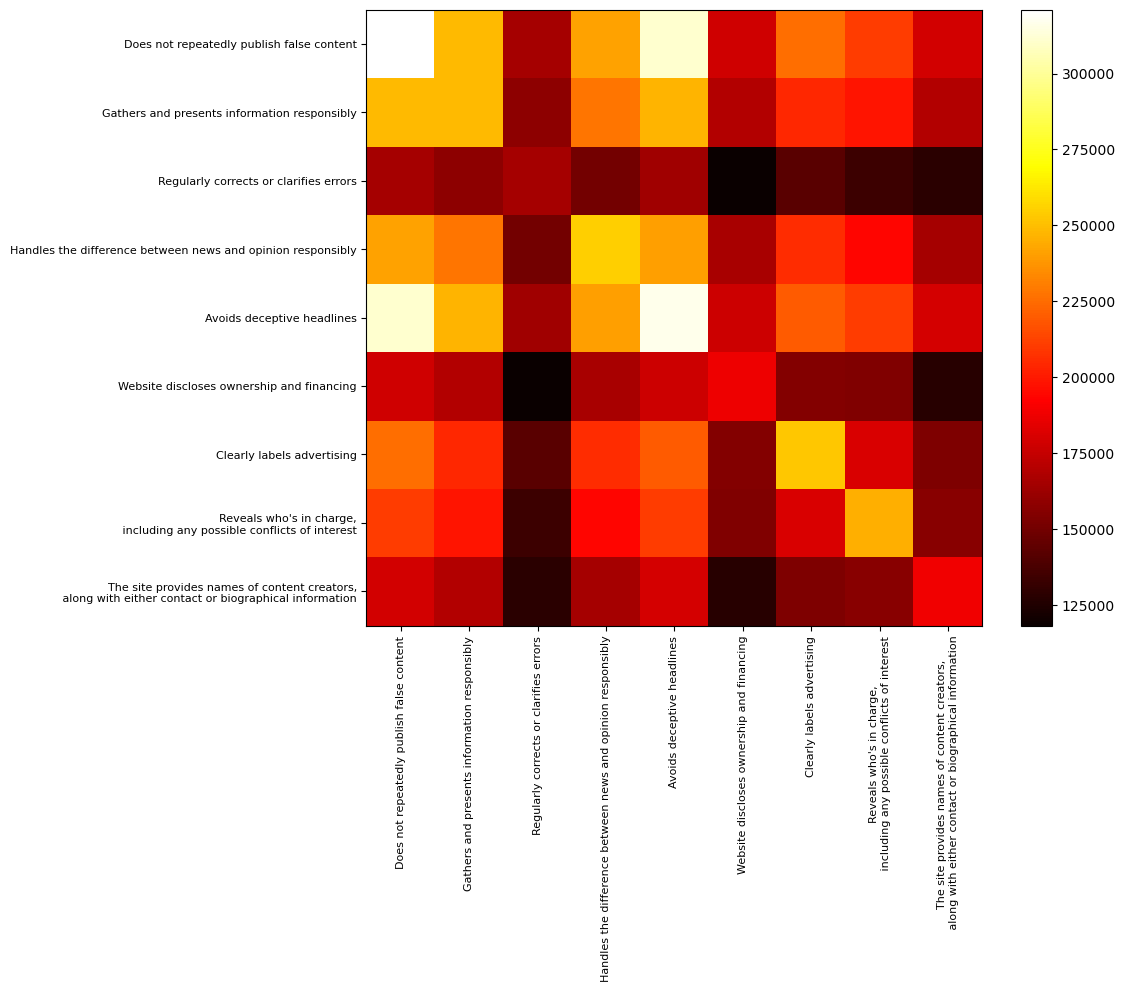

In [81]:
plt.figure(figsize=(10, 8))
plt.imshow(cooccurrence, cmap='hot', interpolation='nearest')
plt.xticks(range(len(cooccurrence)), cooccurrence.columns, rotation=90, fontsize=8)
plt.yticks(range(len(cooccurrence)), cooccurrence.index, fontsize=8)
plt.colorbar()
#for i in range(len(cooccurrence)):
#    for j in range(len(cooccurrence)):
#        plt.text(j, i, cooccurrence.iloc[i, j], ha="center", va="center", color="grey")
plt.show()

In [82]:
#correlation matrix
corr = criteria_df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [83]:
#exploratory factor analysis of criteria
chi_square_value,p_value=calculate_bartlett_sphericity(criteria_df)
chi_square_value, p_value # there is a significant correlation among the variables

(1946539.8369610447, 0.0)

In [86]:
#squared partial correlations
kmo_all,kmo_model=calculate_kmo(criteria_df)
kmo_model #adequate sample size (larger than 0.5)

/home/jluehring/miniconda3/envs/twarcing/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8556324702455227

In [87]:
fa = FactorAnalyzer(rotation=None)
fa.fit(criteria_df, 25)
ev, v = fa.get_eigenvalues()
ev #2 factors have eigenvalues > 1

array([4.59057981, 1.20709782, 0.73956592, 0.66595955, 0.56412765,
       0.46819239, 0.44550013, 0.19990788, 0.11906885])

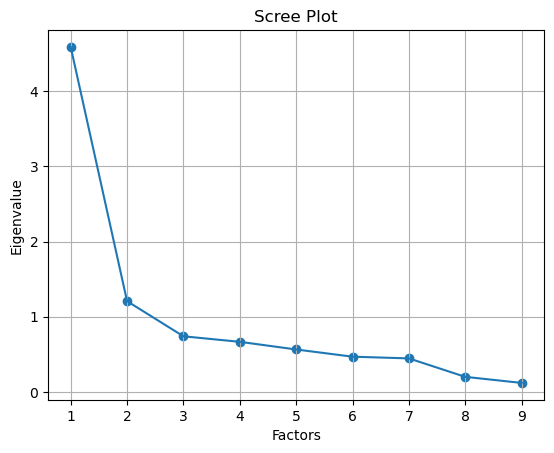

In [88]:
#screeplot
plt.scatter(range(1,criteria_df.shape[1]+1),ev)
plt.plot(range(1,criteria_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [89]:
fa = FactorAnalyzer(n_factors=2, rotation="oblimin")
fa.fit(criteria_df)
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, index=criteria_columns)
loadings_df

0         1
Does not repeatedly publish false content           0.002820  0.949558
Gathers and presents information responsibly        0.761892  0.217985
Regularly corrects or clarifies errors              0.628329  0.051151
Handles the difference between news and opinion...  0.713154  0.097672
Avoids deceptive headlines                          0.045324  0.894837
Website discloses ownership and financing           0.651376 -0.031290
Clearly labels advertising                          0.613917 -0.068877
Reveals who's in charge,\n including any possib...  0.692965 -0.219904
The site provides names of content creators,\n ...  0.674928 -0.035576

In [90]:
#variance explained
fa.get_factor_variance()[0]

array([3.22283893, 1.81741291])

In [91]:
#in percentage
fa.get_factor_variance()[2]*100

array([35.8093214 , 56.00279821])

In [92]:
#regression: which criteria are most important for the overall score?
for criteria in criteria_columns:
    df15 = df15.dropna(subset=[criteria])
    df15 = df15.dropna(subset=["Score"])
    X = df15[criteria]
    y = df15["Score"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(f'Criteria: {criteria}')
    print(f'Coefficient: {model.params[criteria]}')
    print(f'P-value: {model.pvalues[criteria]}')

Criteria: Does not repeatedly publish false content
Coefficient: 66.22567664364061
P-value: 0.0
Criteria: Gathers and presents information responsibly
Coefficient: 63.07831481812715
P-value: 0.0
Criteria: Regularly corrects or clarifies errors
Coefficient: 47.692190753571346
P-value: 0.0
Criteria: Handles the difference between news and opinion responsibly
Coefficient: 55.758612404370496
P-value: 0.0
Criteria: Avoids deceptive headlines
Coefficient: 64.03066931660702
P-value: 0.0
Criteria: Website discloses ownership and financing
Coefficient: 42.09363265202226
P-value: 0.0
Criteria: Clearly labels advertising
Coefficient: 43.419248307782176
P-value: 0.0
Criteria: Reveals who's in charge,
 including any possible conflicts of interest
Coefficient: 32.21144079427973
P-value: 0.0
Criteria: The site provides names of content creators,
 along with either contact or biographical information
Coefficient: 42.16994424178814
P-value: 0.0


In [93]:
#multiple combinations of criteria
combinations = criteria_df.groupby(criteria_columns.tolist()).size().reset_index(name="Counts")
combinations["Percentage"] = combinations["Counts"]/len(df15)*100
combinations.sort_values("Counts", ascending=False).head(10)

Does not repeatedly publish false content  \
268                                        1.0   
89                                         1.0   
2                                          0.0   
260                                        1.0   
225                                        1.0   
0                                          0.0   
224                                        1.0   
267                                        1.0   
266                                        1.0   
4                                          0.0   

     Gathers and presents information responsibly  \
268                                           1.0   
89                                            0.0   
2                                             0.0   
260                                           1.0   
225                                           1.0   
0                                             0.0   
224                                           1.0   
267                                           1.0   
266                                           1.0   
4                                             0.0   

     Regularly corrects or clarifies errors  \
268                                     1.0   
89                                      0.0   
2                                       0.0   
260                                     1.0   
225                                     0.0   
0                                       0.0   
224                                     0.0   
267                                     1.0   
266                                     1.0   
4                                       0.0   

     Handles the difference between news and opinion responsibly  \
268                                                1.0             
89                                                 0.0             
2                                                  0.0             
260                                                1.0             
225                                                1.0             
0                                                  0.0             
224                                                1.0             
267                                                1.0             
266                                                1.0             
4                                                  0.0             

     Avoids deceptive headlines  Website discloses ownership and financing  \
268                         1.0                                        1.0   
89                          1.0                                        0.0   
2                           0.0                                        0.0   
260                         1.0                                        0.0   
225                         1.0                                        1.0   
0                           0.0                                        0.0   
224                         1.0                                        1.0   
267                         1.0                                        1.0   
266                         1.0                                        1.0   
4                           0.0                                        0.0   

     Clearly labels advertising  \
268                         1.0   
89                          0.0   
2                           0.0   
260                         1.0   
225                         1.0   
0                           0.0   
224                         1.0   
267                         1.0   
266                         1.0   
4                           1.0   

     Reveals who's in charge,\n including any possible conflicts of interest  \
268                                                1.0                         
89                                                 0.0                         
2                                                  1.0                         
260                                   

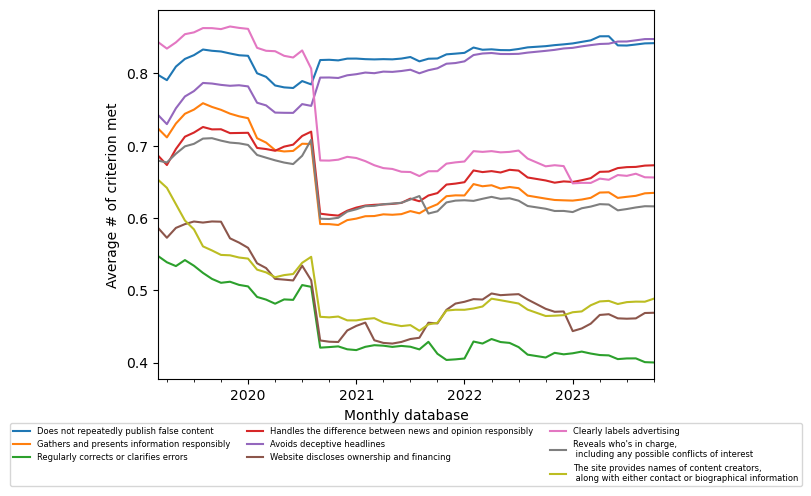

In [94]:
#criteria changes over time 
criteria_avg = df15.groupby("file_month")[criteria_columns].mean()
for col in criteria_columns:
    criteria_avg[col].plot(label=col)
plt.xlabel("Monthly database")
plt.ylabel("Average # of criterion met")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, fontsize=6)
plt.show()

In [95]:
#changes over time per criterion per domain
criteria_dated = df15.groupby("Domain").apply(
                        lambda x: x.sort_values("Last Updated")
                        ).reset_index(drop=True)

criteria_dated.head(3)

UUID        Domain        Parent Domain  \
0  07be0795-9c5e-43ad-932b-e7e0154d5828  100fedup.com  100percentfedup.com   
1  07be0795-9c5e-43ad-932b-e7e0154d5828  100fedup.com  100percentfedup.com   
2  07be0795-9c5e-43ad-932b-e7e0154d5828  100fedup.com  100percentfedup.com   

  Rating  Score            Last Updated Country Language  \
0      N    7.5 2018-09-08 22:26:33.205      US       en   
1      N    7.5 2018-09-08 22:26:33.205      US       en   
2      N    7.5 2018-09-08 22:26:33.205      US       en   

   Does not repeatedly publish false content  \
0                                        0.0   
1                                        0.0   
2                                        0.0   

   Gathers and presents information responsibly  ...  LINKEDIN  IOSAPP  \
0                                           0.0  ...       NaN     NaN   
1                                           0.0  ...       NaN     NaN   
2                                           0.0  ...       NaN     NaN   

   ANDROIDAPP  OTHER  Contact Mail Form URL.1  Communities Served  \
0         NaN    NaN                      NaN                 NaN   
1         NaN    NaN                      NaN                 NaN   
2         NaN    NaN                      NaN                 NaN   

   BrandGuard Segments False Narratives  file_year file_month  
0                  NaN              NaN       2019    2019-03  
1                  NaN              NaN       2019    2019-04  
2                  NaN              NaN       2019    2019-05  

[3 rows x 65 columns]

In [96]:
criteria_diffs = pd.DataFrame()
for criterion in criteria_columns:
    criteria_dated[f'Diff_{criterion}'] = criteria_dated.groupby("Domain")[criterion].diff()
    criteria_diffs[f'Diff_{criterion}'] = criteria_dated[f'Diff_{criterion}']
criteria_diffs.tail(10)

Diff_Does not repeatedly publish false content  \
357754                                             0.0   
357755                                             0.0   
357756                                             0.0   
357757                                             0.0   
357758                                             0.0   
357759                                             0.0   
357760                                             0.0   
357761                                             0.0   
357762                                             0.0   
357763                                             0.0   

        Diff_Gathers and presents information responsibly  \
357754                                                0.0   
357755                                                0.0   
357756                                                0.0   
357757                                                0.0   
357758                                                0.0   
357759                                                0.0   
357760                                                0.0   
357761                                                0.0   
357762                                                0.0   
357763                                                0.0   

        Diff_Regularly corrects or clarifies errors  \
357754                                          0.0   
357755                                          0.0   
357756                                          0.0   
357757                                          0.0   
357758                                          0.0   
357759                                          0.0   
357760                                          0.0   
357761                                          0.0   
357762                                          0.0   
357763                                          0.0   

        Diff_Handles the difference between news and opinion responsibly  \
357754                                                0.0                  
357755                                                0.0                  
357756                                                0.0                  
357757                                                0.0                  
357758                                                0.0                  
357759                                                0.0                  
357760                                                0.0                  
357761                                                0.0                  
357762                                                0.0                  
357763                                                0.0                  

        Diff_Avoids deceptive headlines  \
357754                              0.0   
357755                              0.0   
357756                              0.0   
357757                              0.0   
357758                              0.0   
357759                              0.0   
357760                              0.0   
357761                              0.0   
357762                              0.0   
357763                              0.0   

        Diff_Website discloses ownership and financing  \
357754                                             0.0   
357755                                             0.0   
357756                                             0.0   
357757                                             0.0   
357758                                             0.0   
357759                                             0.0   
357760                                             0.0   
357761                                             0.0   
357762                                             0.0   
357763                                             0.0   

        Diff_Clearly labels advertising  \
357754                              0.0   
357755                              0.0   
357756      

In [97]:
average_change = criteria_diffs.mean()
average_change

Diff_Does not repeatedly publish false content                                                               0.000060
Diff_Gathers and presents information responsibly                                                           -0.000097
Diff_Regularly corrects or clarifies errors                                                                  0.000456
Diff_Handles the difference between news and opinion responsibly                                             0.000427
Diff_Avoids deceptive headlines                                                                              0.000229
Diff_Website discloses ownership and financing                                                              -0.000633
Diff_Clearly labels advertising                                                                             -0.001702
Diff_Reveals who's in charge,\n including any possible conflicts of interest                                -0.000158
Diff_The site provides names of content creators,\n alon

In [98]:
total_change = criteria_diffs.astype(bool).sum()
print(total_change)

Diff_Does not repeatedly publish false content                                                                9022
Diff_Gathers and presents information responsibly                                                             9131
Diff_Regularly corrects or clarifies errors                                                                  10388
Diff_Handles the difference between news and opinion responsibly                                              9340
Diff_Avoids deceptive headlines                                                                               9091
Diff_Website discloses ownership and financing                                                               10986
Diff_Clearly labels advertising                                                                              10181
Diff_Reveals who's in charge,\n including any possible conflicts of interest                                  9894
Diff_The site provides names of content creators,\n along with either contact or

In [99]:
negative_changes = (criteria_diffs < 0).sum()
(negative_changes/criteria_dated.Domain.nunique()*100).sort_values(ascending=False)

Diff_Website discloses ownership and financing                                                               13.266343
Diff_Clearly labels advertising                                                                              10.827594
Diff_Regularly corrects or clarifies errors                                                                   7.745286
Diff_The site provides names of content creators,\n along with either contact or biographical information     6.209778
Diff_Reveals who's in charge,\n including any possible conflicts of interest                                  6.164616
Diff_Handles the difference between news and opinion responsibly                                              1.885514
Diff_Gathers and presents information responsibly                                                             1.738738
Diff_Avoids deceptive headlines                                                                               0.869369
Diff_Does not repeatedly publish false content  

In [100]:
positive_changes = (criteria_diffs > 0).sum()
(positive_changes/criteria_dated.Domain.nunique()*100).sort_values(ascending=False)

Diff_Website discloses ownership and financing                                                               10.771141
Diff_Regularly corrects or clarifies errors                                                                   9.540476
Diff_The site provides names of content creators,\n along with either contact or biographical information     7.846901
Diff_Reveals who's in charge,\n including any possible conflicts of interest                                  5.543638
Diff_Clearly labels advertising                                                                               4.121034
Diff_Handles the difference between news and opinion responsibly                                              3.567799
Diff_Avoids deceptive headlines                                                                               1.772609
Diff_Gathers and presents information responsibly                                                             1.354861
Diff_Does not repeatedly publish false content  

In [101]:
criteria_dated[criteria_dated["Diff_Website discloses ownership and financing"] == -1]["Domain"].unique()

array(['1011now.com', '12thmanrising.com', '13abc.com', ...,
       'yournewswire.com', 'zeit.de', 'zonazealots.com'], dtype=object)

## Political Orientation

In [127]:
print(f'Out of {len(df15)} rows, {df15["Orientation"].isnull().sum()} have no rating for orientation.')
print(f'Out of {len(df15_UUID)}, {df15_UUID["Orientation"].isnull().sum()} have no rating for orientation.')

Out of 357764 rows, 240431 have no rating for orientation.
Out of 44611, 26662 have no rating for orientation.


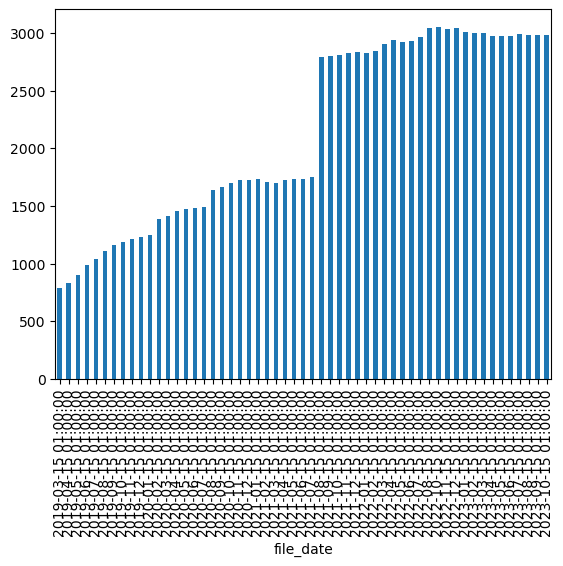

In [148]:
#per file_date, how many rows have a rating for orientation in total
orientation_count = \
    df15\
        .groupby("file_date")["Orientation"]\
        .count()\
        .reset_index()

orientation_count\
    .plot(x="file_date", 
            y="Orientation",
            kind="bar")
plt.legend().remove()


<Axes: xlabel='file_month'>

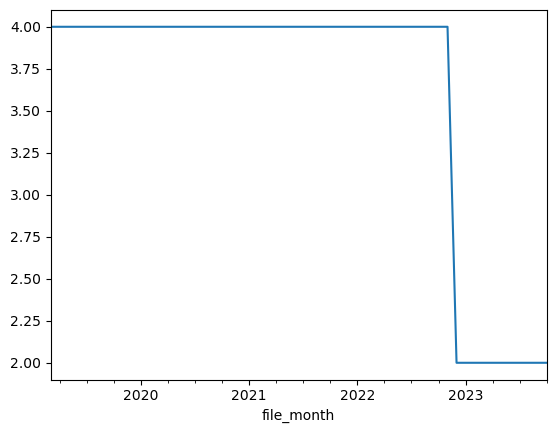

In [104]:
df15\
    .groupby("file_month")["Orientation"]\
    .nunique()\
    .plot(kind="line")

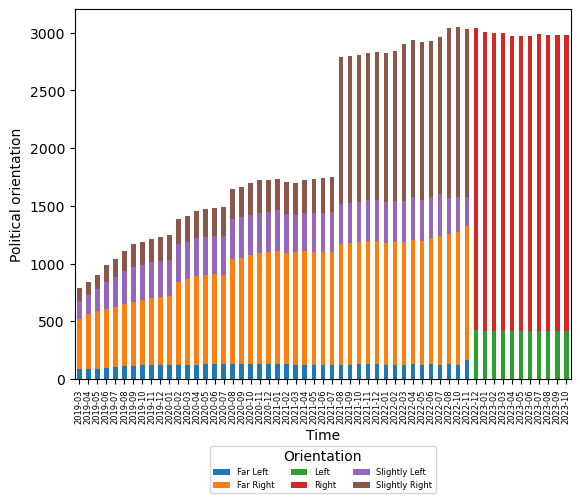

In [122]:
df15\
    .groupby("file_month")["Orientation"]\
    .value_counts(normalize=False)\
    .unstack()\
    .plot(kind="bar", stacked=True)
plt.xlabel("Time")
plt.ylabel("Political orientation")
plt.xticks(fontsize=6)
plt.legend(title="Orientation", loc='lower center', 
           bbox_to_anchor=(0.5, -0.32), 
           ncol=3, fontsize=6)

In [154]:
for df in [df15, df15_UUID]:
    df["Orientation_bi"] = df["Orientation"].replace(
        {"Far Left": "Left", "Slightly Left": "Left", 
         "Slightly Right": "Right", 
         "Far Right": "Right"})

df15["Orientation_bi"].value_counts()

Right    93375
Left     23958
Name: Orientation_bi, dtype: int64

Text(0, 0.5, 'Trustworthiness score')

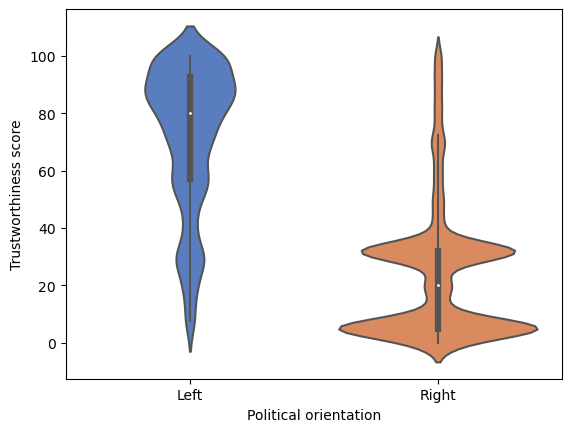

In [161]:
sns.violinplot(x="Orientation_bi", y="Score", 
               data=df15_UUID,
               order=["Left", "Right"],
               palette="muted")
plt.xlabel("Political orientation")
plt.ylabel("Trustworthiness score")

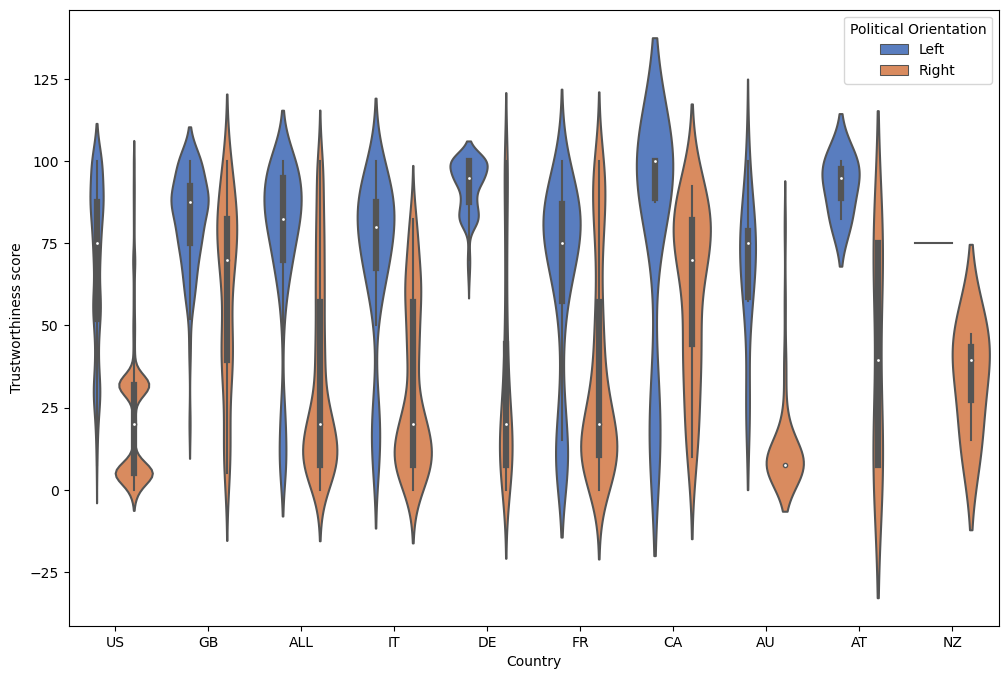

In [173]:
plt.figure(figsize=(12, 8))

unique_countries = df15_UUID["Country"].unique()

sns.violinplot(x="Country", y="Score", 
               hue="Orientation_bi", 
               data=df15_UUID,
               order=unique_countries,  
               hue_order=["Left", "Right"], 
               palette="muted", 
               split=False)

plt.xlabel("Country")
plt.ylabel("Trustworthiness score")

plt.legend(title="Political Orientation", 
           loc="upper right")
plt.show()

/tmp/ipykernel_753005/573818403.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date.Orientation=df_date.Orientation.cat.add_categories("Undefined")
/tmp/ipykernel_753005/573818403.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date.Orientation.fillna("Undefined",inplace=True)


AttributeError: 'numpy.datetime64' object has no attribute 'strftime'

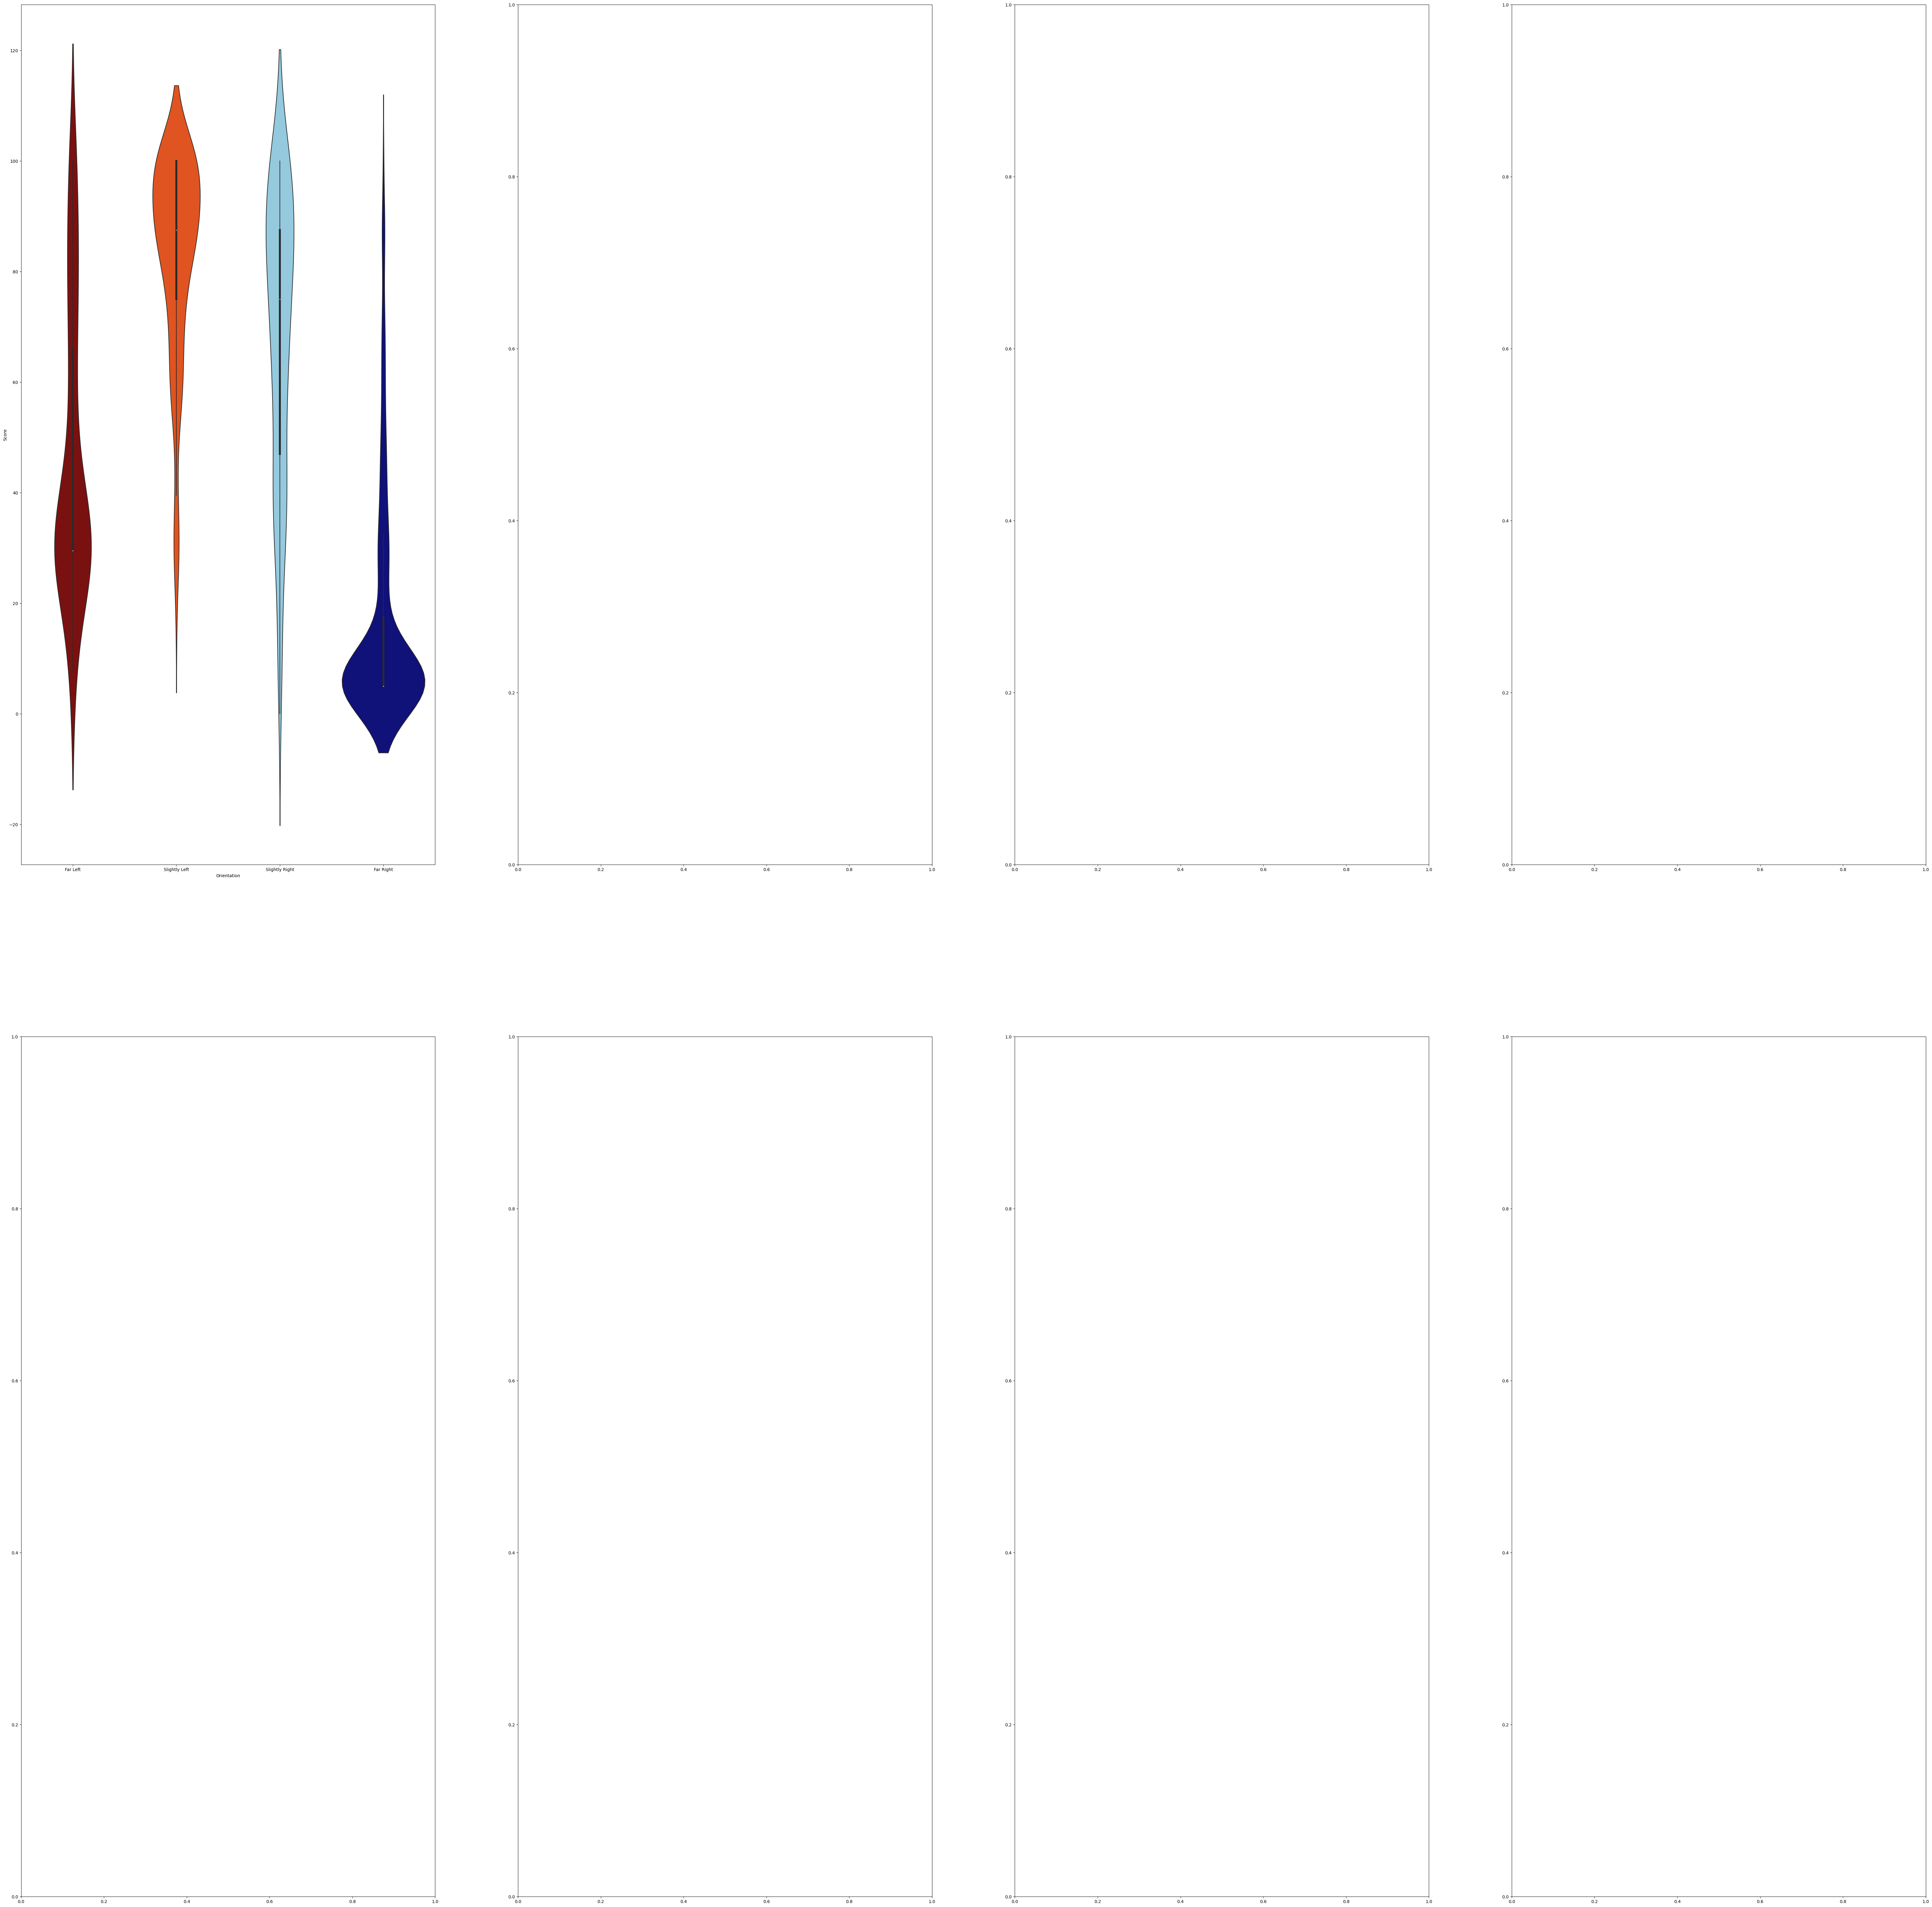

In [113]:
df15_UUID.Orientation.replace({-1:'Far Left',-0.25:'Slightly Left',-0.5:'Left',0.5:'Right',0.25:'Slightly Right',1:'Far Right'},inplace=True)
# make orientation an ordered categorical variable
df15_UUID.Orientation = pd.Categorical(df15_UUID.Orientation, categories=['Far Left','Left','Slightly Left','Slightly Right','Right','Far Right'], ordered=True)

# make a tall fig with 8 subplots
fig, axs=plt.subplots(2,4,figsize=(80, 80), sharey=False)

# left red, far left dark red slightly left orange, slightly right sky blue, slightly right blue, right black
colors={"Left":"r","Far Left":"darkred","Slightly Left":"orangered","Slightly Right":"skyblue","Right":"b","Far Right":"darkblue","Undefined":"gray"}
# for each date, print the number of sources per orientation
for date in df15_UUID.file_date.unique():
    df_date=df15_UUID[df15_UUID.file_date==date] 
    df_date.Orientation=df_date.Orientation.cat.add_categories("Undefined")
    df_date.Orientation.fillna("Undefined",inplace=True)
    # get ax 
    ax=axs.flatten()[list(df15_UUID.file_date.unique()).index(date)]
    # drop undefined
    df_date=df_date[df_date.Orientation!="Undefined"]
    # remove categories with no data
    df_date.Orientation=df_date.Orientation.cat.remove_unused_categories()
    
    # plot the violin plot grouping by orientation 
    sns.violinplot(x="Orientation", y="Score", data=df_date, ax=ax, palette=colors)
    # formatted date as title
    axs.flatten()[list(df15_UUID.file_date.unique()).index(date)].set_title(date.strftime("%Y-%m"))
    # get handles and disable legend
    axs.flatten()[list(df15_UUID.file_date.unique()).index(date)].legend().set_visible(False)
    
    # delete all the ticks that are not between 0 and 100
    ax.set_yticks(np.arange(0, 101, 10))

    # add padding to the top of the plot
    ax.margins(y=0.001)
    ax.set_ylim(-20,120 )
    
    
    #handles, labels = axs.flatten()[list(df15_UUID.file_date.unique()).index(date)].get_legend_handles_labels()
    
    # ticks on the x axis horizontal and smaller
    axs.flatten()[list(df15_UUID.file_date.unique()).index(date)].tick_params(axis="x", rotation=0, labelsize=8)
    # make subplot more spaced
    axs.flatten()[list(df15_UUID.file_date.unique()).index(date)].margins(y=0.1)
    # print on the up left of the plot the number of sources
    axs.flatten()[list(df15_UUID.file_date.unique()).index(date)].text(0.01, 0.95, "n: "+str(len(df_date.loc[df_date.Orientation.notna(),])),verticalalignment='top', horizontalalignment='left', transform=axs.flatten()[list(df15_UUID.file_date.unique()).index(date)].transAxes, fontsize=10)
    
    
# title
fig.suptitle("Distribution of Sources by Orientation and Score over time", fontsize=14)


# make a legend from all the colors
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in df15_UUID.Orientation.unique().dropna()]
labels = df15_UUID.Orientation.unique().dropna()
fig.legend(title="Score", handles=handles, labels=labels, loc='upper center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.96))



# more vertical space between subplots
axs.flatten()[0].margins(y=1)

fig.set_figheight(10)
fig.set_figwidth(20)
plt.show()

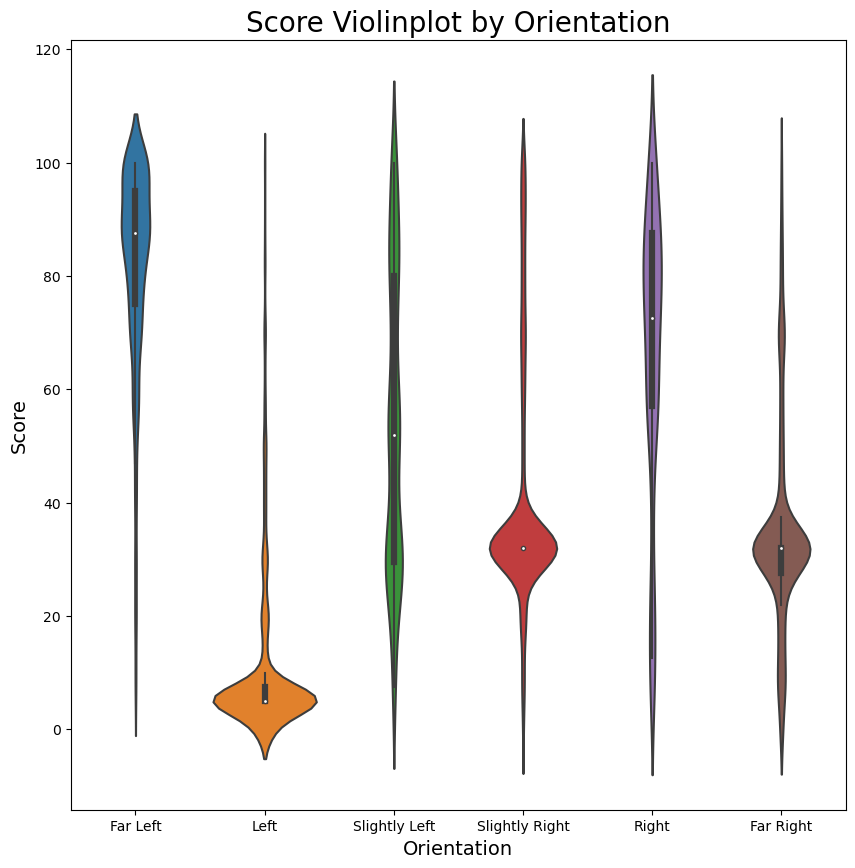

KeyError: 'score_cat'

In [112]:
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(x="Orientation", y="Score", data=df15_UUID, ax=ax)
ax.set_title("Score Violinplot by Orientation", fontsize=20)
ax.set_xlabel("Orientation", fontsize=14)
ax.set_xticklabels(['Far Left','Left','Slightly Left','Slightly Right','Right','Far Right'],rotation=0)
ax.set_ylabel("Score", fontsize=14)
plt.show()

# make Orientation be a scale that goes from Far Left to Far right
df15_UUID['Orientation'] = df15_UUID['Orientation'].replace({'Far Left':-1,'Slightly Left':-0.25,'Left':-0.5,'Center':0,'Right':0.5,'Slightly Right':0.25,'Far Right':1})
# plot counts per orientation category, colored by score (group by score_cat), for the first date of the dataset
df15_UUID.groupby(['Orientation','score_cat']).size().unstack().plot(kind='bar',stacked=True,figsize=(10,5))

# put the labels on the bars
plt.xticks([0,1,2,3,4,5],['Far Left','Left','Slightly Left','Slightly Right','Right','Far Right'],rotation=0)
plt.ylabel("Count")
plt.title("Distribution of Sources by Orientation and Score")

# set the legend title
plt.legend(title="Score")


plt.show()

## MISC RUGGERO

## Popularity
There is no popularity measure in the dataset, I will try to come up with one by myself

In [51]:
websites_test=df_de_last.Domain.sample(10)

import requests

def get_similar_rank(url, api_key="594a88fb2d4e4c0983ea344bcac761d6"):
    # Set up the API endpoint and parameters
    endpoint = f'https://api.similarweb.com/v1/similar-rank/{url}/rank'
    params = {
        'api_key': api_key
    }

    # Send a GET request to the API endpoint with the parameters
    response = requests.get(endpoint, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Extract the global rank from the response JSON
        data = response.json()
        global_rank = data['similar_rank']['rank']
        return global_rank
    else:
        print('Error:', response.status_code)

In [52]:
for website in websites_test:
    print(f"Website: {website}, Global Rank: {get_similar_rank(website)}")

Website: uncutnews.ch, Global Rank: 61030
Error: 404
Website: de.news-front.info, Global Rank: None
Website: tagesschau.de, Global Rank: 512
Website: ndr.de, Global Rank: 1978
Website: rollingstone.de, Global Rank: 21784
Website: swr3.de, Global Rank: 22765
Website: nationalgeographic.de, Global Rank: 25468
Website: snanews.de, Global Rank: 814752
Website: otz.de, Global Rank: 38822
Website: presseportal.de, Global Rank: 9492


Ok now we can order the websites by ranking after getting the ranking for every website

# Showing source to topic connections in relation to their rating

In [53]:
# check if the csv with the rankings was already cached, else make it
if os.path.isfile("df_de_with_rankings.csv"):
    df_de_last=pd.read_csv("df_de_with_rankings.csv")
else:
    df_de_last["similar_rank"]=df_de_last.Domain.apply(get_similar_rank)
    df_de_last["similar_rank"].fillna(1000000000000,inplace=True) # fill na with a big number to fix missing rankings
    df_de_last.to_csv("df_de_with_rankings.csv",index=False)



In [54]:
# make a networkx graph source-topic
import networkx as nx


# create an empty graph
G = nx.Graph()

# making every topics a string
df_de_last.Topics=df_de_last.Topics.astype(str)

# iterate over every row of df_de and extract the topics as nodes to connect to
for index, row in df_de_last.iterrows():
    if row['Topics'] == "nan":
        continue
    topics = row['Topics'].split(',')
    for topic in topics:
        # add an edge between the source and the topic
        # the edge should have an attribute rating with the value of the score
        G.add_edge(row['Domain'], topic, type='source-topic', score=row['Score'])
        # make the topic node a 'topic' node
        G.nodes[topic]['type'] = 'topic'
        G.nodes[row['Domain']]['type'] = 'source'
        G.nodes[row['Domain']]['rating'] = row['Rating']
        G.nodes[row['Domain']]['ranking'] = row['similar_rank']
        G.nodes[row['Domain']]['score'] = row['Score']
        G.nodes[row['Domain']]['orientation'] = row['Orientation']

|    | Topic                         |   avg_score |   Source count |
|---:|:------------------------------|------------:|---------------:|
|  0 | Local News                    |     92.8125 |             24 |
|  1 | General News                  |     92.3846 |             26 |
|  2 | Political news or commentary  |     72.6604 |            267 |
|  3 | Conspiracy theories or hoaxes |     19.2537 |             69 |
|  4 | General / Local News          |     86.75   |             10 |
|  5 | Business or Personal Finance  |     86.0455 |             13 |
|  6 | Parenting                     |     85      |              2 |
|  7 | Religion                      |     95      |              1 |
|  8 | Science                       |     83.75   |              4 |
|  9 | Technology                    |     89.6429 |              7 |
| 10 | Health or medical information |     53      |             65 |
| 11 | Lifestyle                     |     75.1875 |              8 |
| 12 | Fashion                       |     78.75   |              2 |
| 13 | Viral content                 |     78.25   |              6 |
| 14 | Celebrity news                |     78.5357 |             14 |
| 15 | Entertainment                 |     78.2105 |             19 |
| 16 | Sports and athletics          |     94.375  |              4 |

['achgut.com', 'pravda-tv.com', 'pi-news.net', 'anti-spiegel.ru', 'uncutnews.ch']
['zentrum-der-gesundheit.de', 'pravda-tv.com', 'uncutnews.ch', 'report24.news', 'kla.tv']


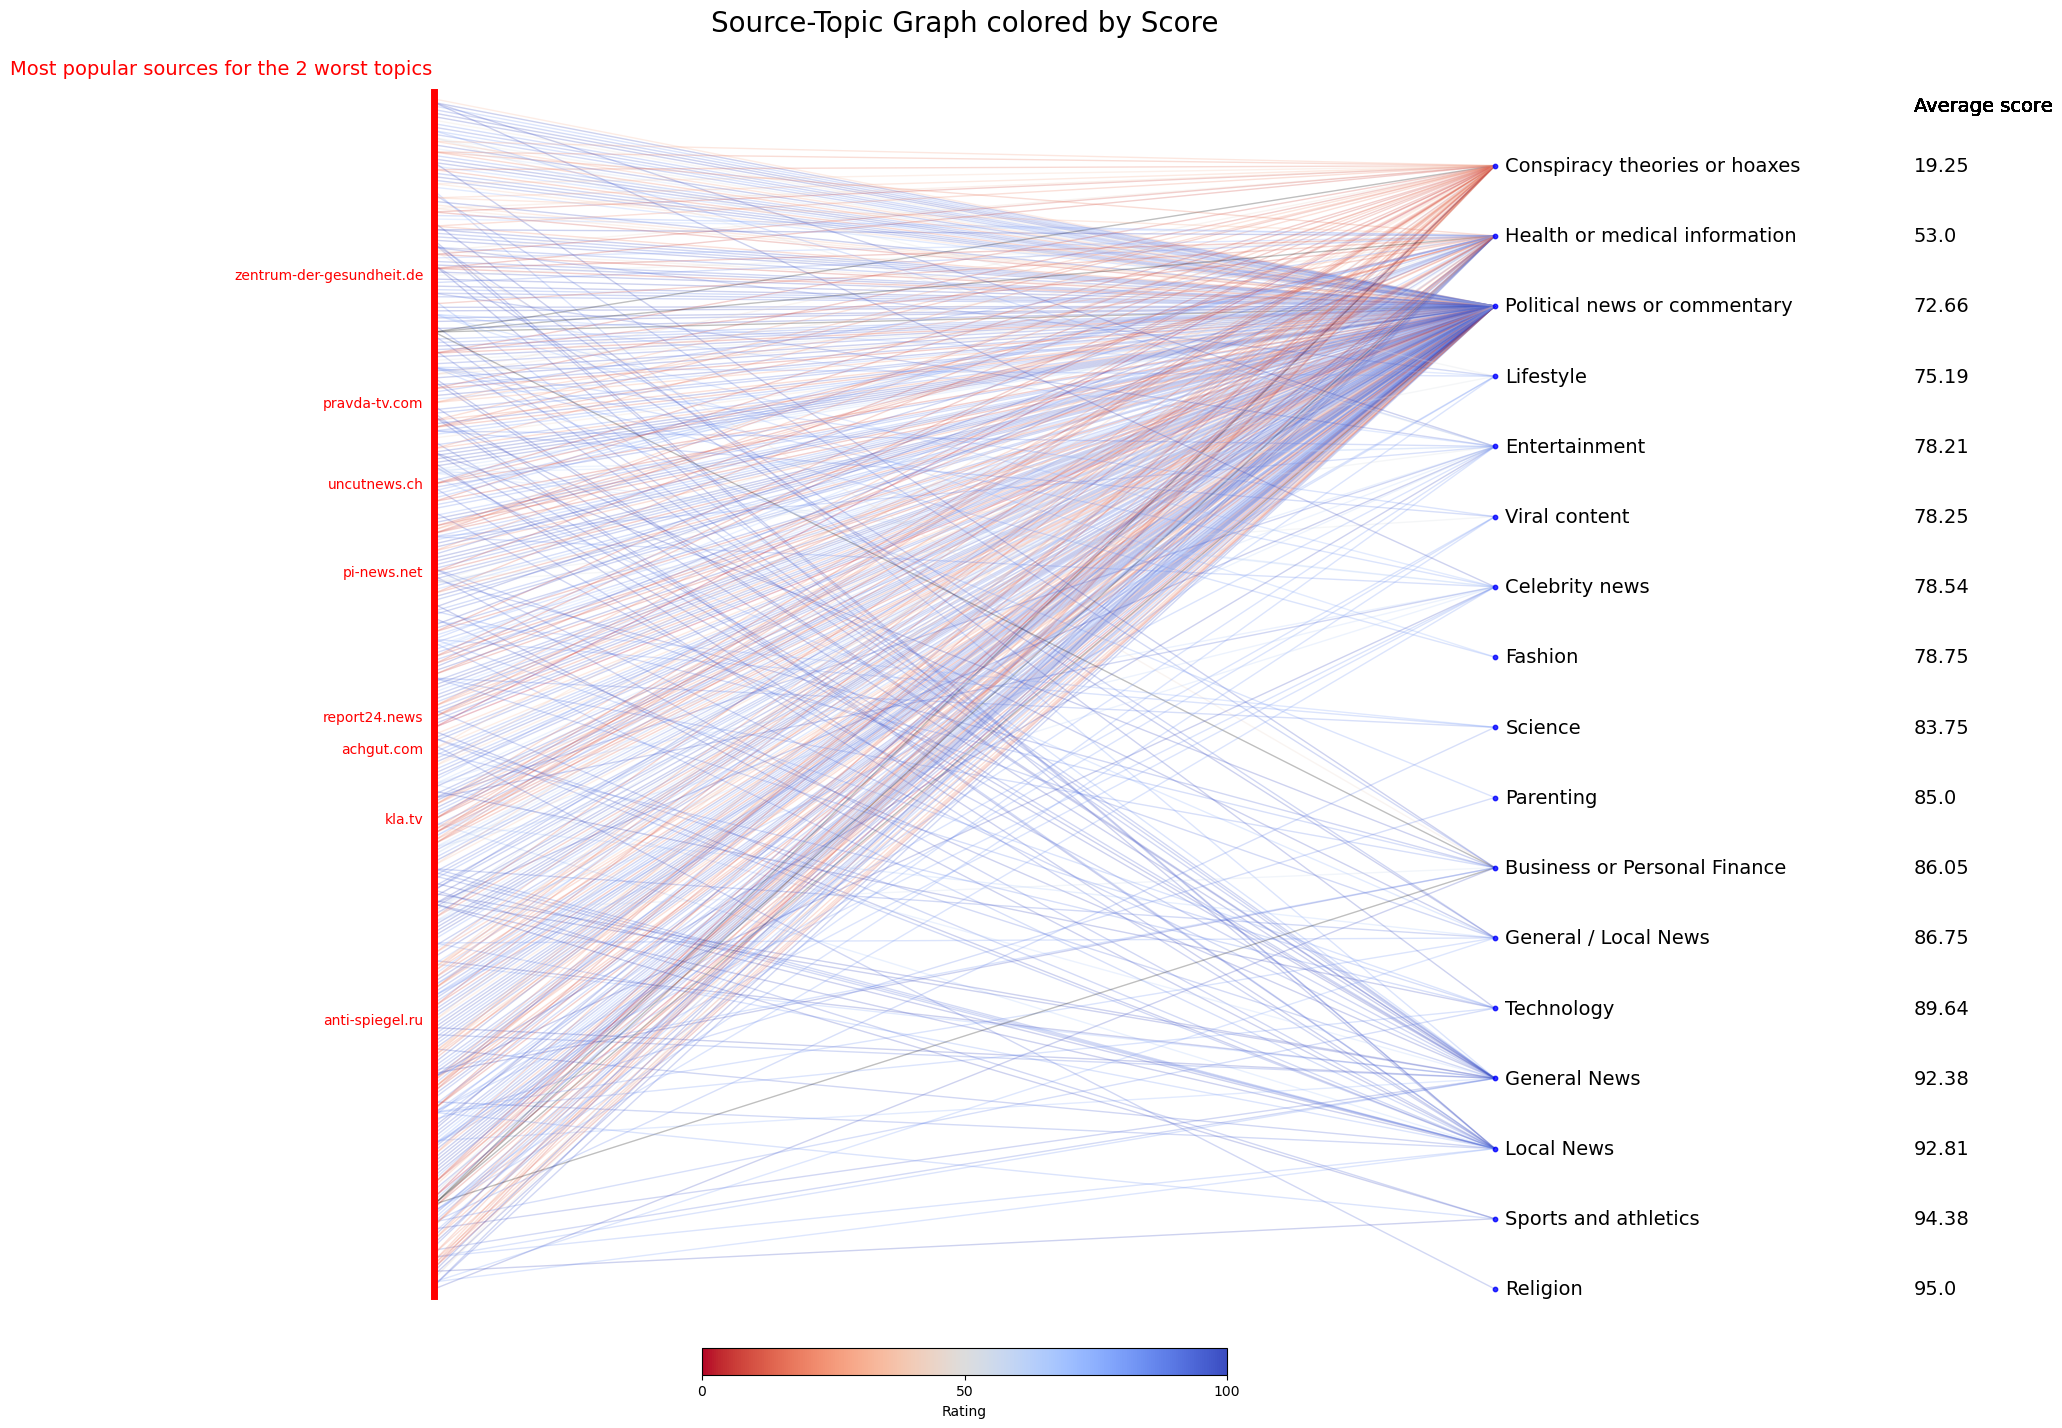

In [55]:
# lets graph this
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

# first we need to get the positions of the nodes, sources on the left and topics on the right
non_source_nodes = [v for v in G.nodes() if G.nodes[v]['type']=='topic']
num_non_source_nodes = len(non_source_nodes)
pos={}
len_sources = len(G.nodes())-num_non_source_nodes
# order the source nodes randomly
random_sources=[node for node in G.nodes() if G.nodes[node]['type']=='source']
random.shuffle(random_sources)

for i,node in enumerate(random_sources):
    if G.nodes[node]['type']=='source':
        pos[node]=(-1,len(G.nodes())/len_sources*i*1.2)
        

# initiate mrk table Topic | avg_score 
table = pd.DataFrame(columns=["Topic","avg_score","Source count"])

# order the topic nodes by the average score of the edges
# first get the average score of the edges
for node in non_source_nodes:
    G.nodes[node]['avg_score'] = np.nanmean([edge[2]['score'] for edge in G.edges(node,data=True)])
    # adding row to markdown table topic | avg_score
    G.nodes[node]['count'] = len([edge[2]['score'] for edge in G.edges(node,data=True)])
    table = pd.concat([table,pd.DataFrame([[node,G.nodes[node]['avg_score'],G.nodes[node]["count"]]],columns=["Topic","avg_score","Source count"])],ignore_index=True)
    
# print the table
display((Markdown(table.to_markdown())))
    

# order the nodes by the average score
non_source_nodes = [node for score,node in sorted([(G.nodes[node]['avg_score'],node) for node in non_source_nodes],reverse=True)]

for i,node in enumerate(non_source_nodes):
    pos[node]=(1,len(G.nodes())/num_non_source_nodes*i*1.2)
        



# lets get the edges and their ratings
# the color of the edge will be the rating

# make a color map that goes from blue to red but reverse it so that red is the lowest rating
cmap = plt.cm.coolwarm.reversed()
 
# get the ratings
ratings = [edge[2]['score'] for edge in G.edges(data=True)]


#big graph
plt.figure(figsize=(10,20))

# plotting the edges with the ratings as colors, using the coolwarm colormap
nx.draw_networkx_edges(G,pos,edge_color=ratings,edge_cmap=cmap,edge_vmin=min(ratings),edge_vmax=max(ratings), alpha=0.25)



# Add a straight line at x=-1 on the left
plt.axvline(x=-1, color='r', alpha=1,ymin=0.04,ymax=0.96, linewidth=5,linestyle='-')
# plot topics
nx.draw_networkx_nodes(G,pos,nodelist=[v for v in G.nodes() if G.nodes[v]['type']=='topic'],node_size=10,node_color='b',alpha=0.8)

# adding labels on the right for the topics

# bump the networkx labels more right by 2 pixels
for _,t in nx.draw_networkx_labels(G,pos,labels={v:v for v in G.nodes() if G.nodes[v]['type']=='topic'},font_size=14, horizontalalignment='left').items():
    t.set_rotation(0)
    t.set_ha('left')
    
    t.set_x(t.get_position()[0]+0.02)
    
    # right to that position add a label with the average score
    
    # get furthermost left position of the node
    
    # assuming you have a text object called t
    
    pos_node = t.get_position()
    pos_node=(pos_node[0]+0.75,pos_node[1])
    node = t.get_text()
    node= G.nodes[node]
    plt.text(pos_node[0]+0.02,pos_node[1],str(round(node['avg_score'],2)),horizontalalignment='left',verticalalignment='center',transform=plt.gca().transData, fontsize=14)
    
    # print on top that this is the average score
    plt.text(pos_node[0]+0.02,len_sources*1.25,"Average score",horizontalalignment='left',verticalalignment='center',transform=plt.gca().transData,fontsize=14)


worse_2_non_sources = [node for score,node in sorted([(G.nodes[node]['avg_score'],node) for node in non_source_nodes],reverse=False)[:2]]

# get top 5 sources by similarweb for each of the 2 worst topics
bad_sources = []
for non_source in worse_2_non_sources:
    bad_sources_nodes=[edge[1] for edge in G.edges(non_source,data=True)]
    # keep only "N" rated nodes
    bad_sources_nodes = [node for node in bad_sources_nodes if G.nodes[node]['rating']=="N"]
    # sort them by similarweb rank
    bad_sources_nodes = sorted(bad_sources_nodes,key=lambda x:G.nodes[x]['ranking'])[:5]
    print(bad_sources_nodes)
    bad_sources.extend(bad_sources_nodes)
    
# add a label for the top 5 sources by ranking, bump it left by 2 pixels
for _,t in nx.draw_networkx_labels(G,pos,labels={v:v for v in bad_sources},font_size=10, horizontalalignment='left', font_color="r").items():
    t.set_rotation(0)
    t.set_ha('right')
    t.set_x(t.get_position()[0]-0.02)

# # get good sources
# good_sources = [v for v in G.nodes() if G.nodes[v]['type']=='source' and G.nodes[v]['rating']=="T"]
# # add a label to the top 5 sources by ranking, bump it left by 2 pixels
# for _,t in nx.draw_networkx_labels(G,pos,labels={v:v for v in sorted(good_sources,key=lambda x:G.nodes[x]['ranking'])[:5]},font_size=10, horizontalalignment='left', font_color="b").items():
#     t.set_rotation(0)
#     t.set_ha('right')
#     t.set_x(t.get_position()[0]-0.02)
    
    
# # get bad sources
# bad_sources = [v for v in G.nodes() if G.nodes[v]['type']=='source' and G.nodes[v]['rating']=="N"]

# add a label to the top 5 bad sources by ranking, bump it left by 2 pixels
# for _,t in nx.draw_networkx_labels(G,pos,labels={v:v for v in sorted(bad_sources,key=lambda x:G.nodes[x]['ranking'])[:5]},font_size=10, horizontalalignment='left', font_color="r").items():
#     t.set_rotation(0)
#     t.set_ha('right')
#     t.set_x(t.get_position()[0]-0.02)
    
    
    



plt.axis('off')
# adding the cmap as a colorbar, at the bottom
cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap),label='Rating',orientation='horizontal',shrink=0.3,pad=0)
cbar.set_ticks([0,0.5,1])
cbar.set_ticklabels(['0',"50",'100'])

plt.margins(x=0.25, y=0)
plt.subplots_adjust(right=1.75, left=0)
plt.title("Source-Topic Graph colored by Score", fontsize=20)
ymax=plt.ylim()[1]

plt.text(-1.80,ymax*0.95+10, "Most popular sources for the 2 worst topics", fontsize=14, color="r")

# # add a legend on the top left saying "Top 5 Good Sources" and "Top 5 Bad Sources"
# plt.text(-1.5,plt.ylim()[1]*0.95+10, "Top 5 Good Sources", fontsize=14, color="b")
# plt.text(-1.5,plt.ylim()[1]*0.95, "Top 5 Bad Sources", fontsize=14, color="r")
# saving graph in hq
plt.savefig('source_topic_graph.png', dpi=300, bbox_inches='tight')

plt.show()


In [56]:
# make a df with the sources, their attributes and the topics they are connected to
source_df = pd.DataFrame(columns=["Source","Rating","Score","Ranking","Topics"])
source_df["Source"] = [v for v in G.nodes() if G.nodes[v]['type']=='source']
source_df["Score"] = [G.nodes[v]['score'] for v in G.nodes() if G.nodes[v]['type']=='source']
source_df["Rating"] = [G.nodes[v]['rating'] for v in G.nodes() if G.nodes[v]['type']=='source']
source_df["Ranking"] = [G.nodes[v]['ranking'] for v in G.nodes() if G.nodes[v]['type']=='source']
source_df["Topics"] = [[edge[1] for edge in G.edges(v) if G.nodes[edge[1]]['type']=='topic'] for v in G.nodes() if G.nodes[v]['type']=='source']

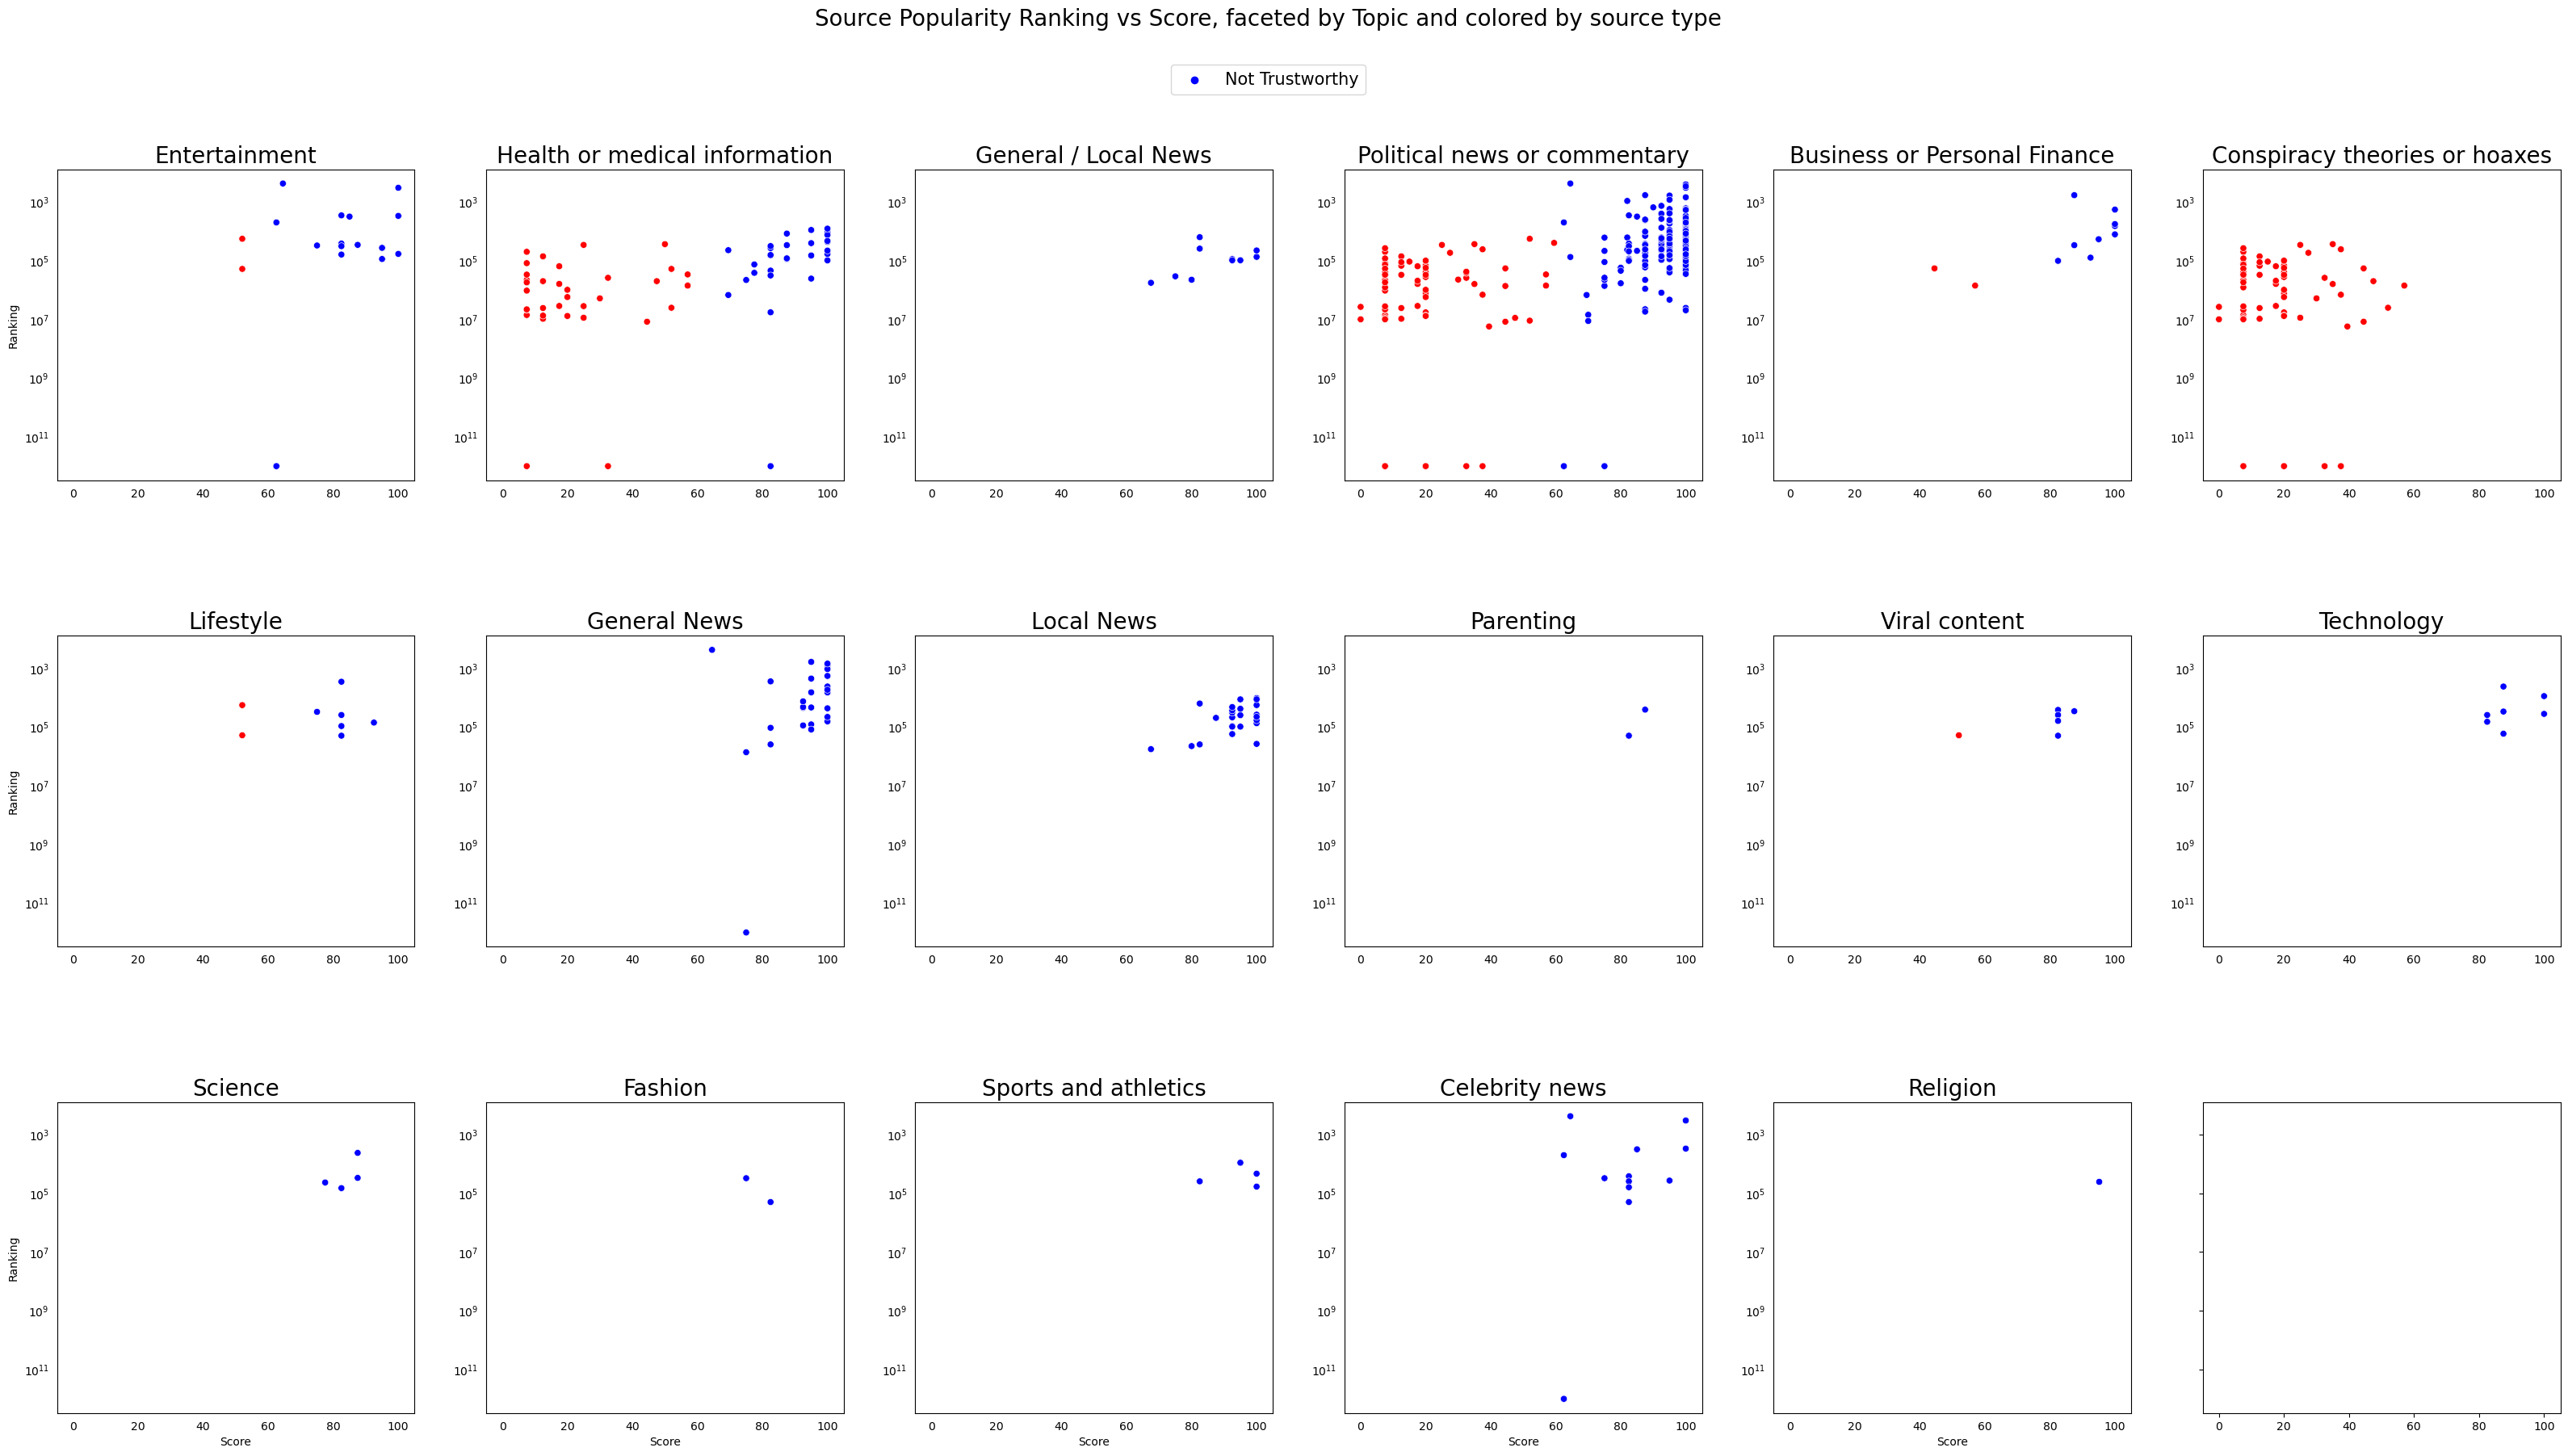

In [57]:
# faceted plot log ranking by score, facted by topic
import seaborn as sns
import matplotlib
topics=set([topic for sublist in source_df["Topics"] for topic in sublist])
lent= len(topics)
fig, axs = plt.subplots(3,6,figsize=(40,20),sharey=True, sharex=True,)
# make it show the ticks labels everywhere despite sharing it

# make every subplot taller
fig.subplots_adjust(hspace=0.5)
for topic in topics:
    topic_df = source_df[source_df["Topics"].apply(lambda x: topic in x)]
    # get the axes for this topic
    ax=axs.flatten()[list(topics).index(topic)]
    
    # dictionary for hues T is blue, N is red
    hues={"T":"b","N":"r","P":"w"}

    # plot the scatterplot, use the hues dict for the colot
    sns.scatterplot(data=topic_df, x="Score", y="Ranking", hue="Rating", palette=hues, ax=ax)
    ax.set_title(topic)
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)
    # turn off legend
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    
    # make subplot title bigger
    ax.title.set_size(20)

fig.suptitle("Source Popularity Ranking vs Score, faceted by Topic and colored by source type", fontsize=20)
# make a global legend, with the color of the Rating
fig.legend(labels=["Not Trustworthy","Trustworthy"], loc='upper center', ncol=2, fontsize=15, handles=handles, bbox_to_anchor=(0.5, 0.95))

# substitute T and N with Trastworthy and Not Trustworthy in the legneds

plt.show()


In [58]:
# group by topic and get the top 5 sources by ranking for each rating
for topic in topics:
    topic_df = source_df[source_df["Topics"].apply(lambda x: topic in x)]
    topic_df = topic_df.sort_values("Ranking")[["Source","Ranking","Score","Rating"]]
    top_5_pos=topic_df[topic_df["Rating"]=="T"].head(5)
    top_5_neg=topic_df[topic_df["Rating"]=="N"].head(5)
    display(Markdown("### Most popular positive sources for Topic: "+topic))
    display(Markdown(top_5_pos.to_markdown()))
    display(Markdown("### Most popular negative sources for Topic: "+topic))
    display(Markdown(top_5_neg.to_markdown()))
    
    

### Most popular positive sources for Topic: Entertainment

|     | Source       |   Ranking |   Score | Rating   |
|----:|:-------------|----------:|--------:|:---------|
|  53 | bild.de      |       235 |    64.5 | T        |
| 212 | gmx.net      |       329 |   100   | T        |
| 329 | vice.com     |      2864 |    82.5 | T        |
|  92 | tz.de        |      2983 |   100   | T        |
| 300 | derwesten.de |      3151 |    85   | T        |

### Most popular negative sources for Topic: Entertainment

|     | Source       |   Ranking |   Score | Rating   |
|----:|:-------------|----------:|--------:|:---------|
| 227 | servustv.com |     17954 |      52 | N        |
| 225 | heftig.de    |    191154 |      52 | N        |

### Most popular positive sources for Topic: Health or medical information

|     | Source               |   Ranking |   Score | Rating   |
|----:|:---------------------|----------:|--------:|:---------|
| 222 | utopia.de            |      8106 |   100   | T        |
|  83 | presseportal.de      |      9019 |    95   | T        |
| 147 | apotheken-umschau.de |     10897 |   100   | T        |
| 125 | netdoktor.de         |     11950 |    87.5 | T        |
| 151 | spektrum.de          |     13261 |   100   | T        |

### Most popular negative sources for Topic: Health or medical information

|     | Source                    |   Ranking |   Score | Rating   |
|----:|:--------------------------|----------:|--------:|:---------|
| 101 | zentrum-der-gesundheit.de |     27395 |    50   | N        |
| 277 | pravda-tv.com             |     29054 |    25   | N        |
|  88 | uncutnews.ch              |     49898 |     7.5 | N        |
| 238 | report24.news             |     71212 |    12.5 | N        |
|  46 | kla.tv                    |    121638 |     7.5 | N        |

### Most popular positive sources for Topic: General / Local News

|     | Source               |   Ranking |   Score | Rating   |
|----:|:---------------------|----------:|--------:|:---------|
| 231 | tt.com               |     15838 |    82.5 | T        |
| 137 | gentside.de          |     38914 |    82.5 | T        |
| 254 | bw24.de              |     44909 |   100   | T        |
|  50 | siegener-zeitung.de  |     74207 |   100   | T        |
|  21 | esslinger-zeitung.de |     88376 |    92.5 | T        |

### Most popular negative sources for Topic: General / Local News

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular positive sources for Topic: Political news or commentary

|     | Source      |   Ranking |   Score | Rating   |
|----:|:------------|----------:|--------:|:---------|
|  53 | bild.de     |       235 |    64.5 | T        |
| 199 | t-online.de |       253 |   100   | T        |
| 214 | web.de      |       292 |   100   | T        |
| 212 | gmx.net     |       329 |   100   | T        |
|  27 | n-tv.de     |       587 |    87.5 | T        |

### Most popular negative sources for Topic: Political news or commentary

|     | Source          |   Ranking |   Score | Rating   |
|----:|:----------------|----------:|--------:|:---------|
| 227 | servustv.com    |     17954 |    52   | N        |
| 213 | reitschuster.de |     24803 |    59.5 | N        |
|  90 | achgut.com      |     27310 |    35   | N        |
| 277 | pravda-tv.com   |     29054 |    25   | N        |
|  91 | pi-news.net     |     37574 |     7.5 | N        |

### Most popular positive sources for Topic: Business or Personal Finance

|     | Source             |   Ranking |   Score | Rating   |
|----:|:-------------------|----------:|--------:|:---------|
|  27 | n-tv.de            |       587 |    87.5 | T        |
| 179 | faz.net            |      1819 |   100   | T        |
| 140 | handelsblatt.com   |      5660 |   100   | T        |
| 106 | businessinsider.de |      6593 |   100   | T        |
| 258 | deraktionaer.de    |     12692 |   100   | T        |

### Most popular negative sources for Topic: Business or Personal Finance

|     | Source        |   Ranking |   Score | Rating   |
|----:|:--------------|----------:|--------:|:---------|
|  47 | mmnews.de     |    183166 |    44.5 | N        |
| 107 | neopresse.com |    706797 |    57   | N        |

### Most popular positive sources for Topic: Conspiracy theories or hoaxes

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular negative sources for Topic: Conspiracy theories or hoaxes

|     | Source          |   Ranking |   Score | Rating   |
|----:|:----------------|----------:|--------:|:---------|
|  90 | achgut.com      |     27310 |    35   | N        |
| 277 | pravda-tv.com   |     29054 |    25   | N        |
|  91 | pi-news.net     |     37574 |     7.5 | N        |
| 275 | anti-spiegel.ru |     40976 |    37.5 | N        |
|  88 | uncutnews.ch    |     49898 |     7.5 | N        |

### Most popular positive sources for Topic: Lifestyle

|     | Source        |   Ranking |   Score | Rating   |
|----:|:--------------|----------:|--------:|:---------|
| 329 | vice.com      |      2864 |    82.5 | T        |
| 250 | vogue.de      |     30423 |    75   | T        |
| 137 | gentside.de   |     38914 |    82.5 | T        |
| 301 | jetzt.de      |     70551 |    92.5 | T        |
| 123 | tip-berlin.de |     92708 |    82.5 | T        |

### Most popular negative sources for Topic: Lifestyle

|     | Source       |   Ranking |   Score | Rating   |
|----:|:-------------|----------:|--------:|:---------|
| 227 | servustv.com |     17954 |      52 | N        |
| 225 | heftig.de    |    191154 |      52 | N        |

### Most popular positive sources for Topic: General News

|     | Source        |   Ranking |   Score | Rating   |
|----:|:--------------|----------:|--------:|:---------|
|  53 | bild.de       |       235 |    64.5 | T        |
| 176 | tagesschau.de |       605 |    95   | T        |
| 190 | focus.de      |       692 |   100   | T        |
|  39 | spiegel.de    |       805 |   100   | T        |
| 172 | zdf.de        |      1059 |   100   | T        |

### Most popular negative sources for Topic: General News

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular positive sources for Topic: Local News

|     | Source                     |   Ranking |   Score | Rating   |
|----:|:---------------------------|----------:|--------:|:---------|
|  71 | ruhrnachrichten.de         |     10345 |   100   | T        |
| 331 | stuttgarter-nachrichten.de |     11417 |   100   | T        |
| 122 | abendblatt.de              |     11419 |    95   | T        |
| 231 | tt.com                     |     15838 |    82.5 | T        |
| 168 | freiepresse.de             |     17873 |   100   | T        |

### Most popular negative sources for Topic: Local News

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular positive sources for Topic: Parenting

|    | Source    |   Ranking |   Score | Rating   |
|---:|:----------|----------:|--------:|:---------|
| 26 | eltern.de |     25555 |    87.5 | T        |
| 43 | miss.at   |    197521 |    82.5 | T        |

### Most popular negative sources for Topic: Parenting

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular positive sources for Topic: Viral content

|     | Source          |   Ranking |   Score | Rating   |
|----:|:----------------|----------:|--------:|:---------|
| 136 | rollingstone.de |     26105 |    82.5 | T        |
| 259 | buzzfeed.de     |     28943 |    87.5 | T        |
| 137 | gentside.de     |     38914 |    82.5 | T        |
| 260 | faktastisch.de  |     61839 |    82.5 | T        |
|  43 | miss.at         |    197521 |    82.5 | T        |

### Most popular negative sources for Topic: Viral content

|     | Source    |   Ranking |   Score | Rating   |
|----:|:----------|----------:|--------:|:---------|
| 225 | heftig.de |    191154 |      52 | N        |

### Most popular positive sources for Topic: Technology

|     | Source        |   Ranking |   Score | Rating   |
|----:|:--------------|----------:|--------:|:---------|
|  70 | heise.de      |      4171 |    87.5 | T        |
| 164 | golem.de      |      8859 |   100   | T        |
|  33 | futurezone.at |     29701 |    87.5 | T        |
| 116 | t3n.de        |     35680 |   100   | T        |
| 137 | gentside.de   |     38914 |    82.5 | T        |

### Most popular negative sources for Topic: Technology

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular positive sources for Topic: Science

|     | Source                |   Ranking |   Score | Rating   |
|----:|:----------------------|----------:|--------:|:---------|
|  70 | heise.de              |      4171 |    87.5 | T        |
|  33 | futurezone.at         |     29701 |    87.5 | T        |
| 257 | nationalgeographic.de |     42587 |    77.5 | T        |
|  63 | scinexx.de            |     66226 |    82.5 | T        |

### Most popular negative sources for Topic: Science

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular positive sources for Topic: Fashion

|     | Source   |   Ranking |   Score | Rating   |
|----:|:---------|----------:|--------:|:---------|
| 250 | vogue.de |     30423 |    75   | T        |
|  43 | miss.at  |    197521 |    82.5 | T        |

### Most popular negative sources for Topic: Fashion

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular positive sources for Topic: Sports and athletics

|     | Source            |   Ranking |   Score | Rating   |
|----:|:------------------|----------:|--------:|:---------|
|  83 | presseportal.de   |      9019 |    95   | T        |
| 180 | fitforfun.de      |     21271 |   100   | T        |
| 137 | gentside.de       |     38914 |    82.5 | T        |
|  98 | fuldaerzeitung.de |     58780 |   100   | T        |

### Most popular negative sources for Topic: Sports and athletics

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular positive sources for Topic: Celebrity news

|     | Source       |   Ranking |   Score | Rating   |
|----:|:-------------|----------:|--------:|:---------|
|  53 | bild.de      |       235 |    64.5 | T        |
| 212 | gmx.net      |       329 |   100   | T        |
|  92 | tz.de        |      2983 |   100   | T        |
| 300 | derwesten.de |      3151 |    85   | T        |
| 236 | oe24.at      |      4983 |    62.5 | T        |

### Most popular negative sources for Topic: Celebrity news

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

### Most popular positive sources for Topic: Religion

|    | Source        |   Ranking |   Score | Rating   |
|---:|:--------------|----------:|--------:|:---------|
| 32 | katholisch.de |     39391 |      95 | T        |

### Most popular negative sources for Topic: Religion

| Source   | Ranking   | Score   | Rating   |
|----------|-----------|---------|----------|

# Topic - Orientation interaction

Let's see if something can be said about the distribution of sources of various orientations between topics 

In [68]:
source_df["Orientation"] = source_df["Source"].apply(lambda x: df_de_last[df_de_last["Domain"]==x]["Orientation"].values[0] if x in df_de_last["Domain"].values else None)

In [69]:
source_df.Orientation.value_counts()

Orientation
Right    57
Left     14
Name: count, dtype: int64

In [70]:
source_df.columns

Index(['Source', 'Rating', 'Score', 'Ranking', 'Topics', 'Orientation'], dtype='object')

In [71]:
# drop sources without scores 
source_df.dropna(subset=["Score"],inplace=True)

We don't many sources or political leaning nuance in this latest dataset, but we can still see how they relate to topics

In [72]:
17*2*5

170

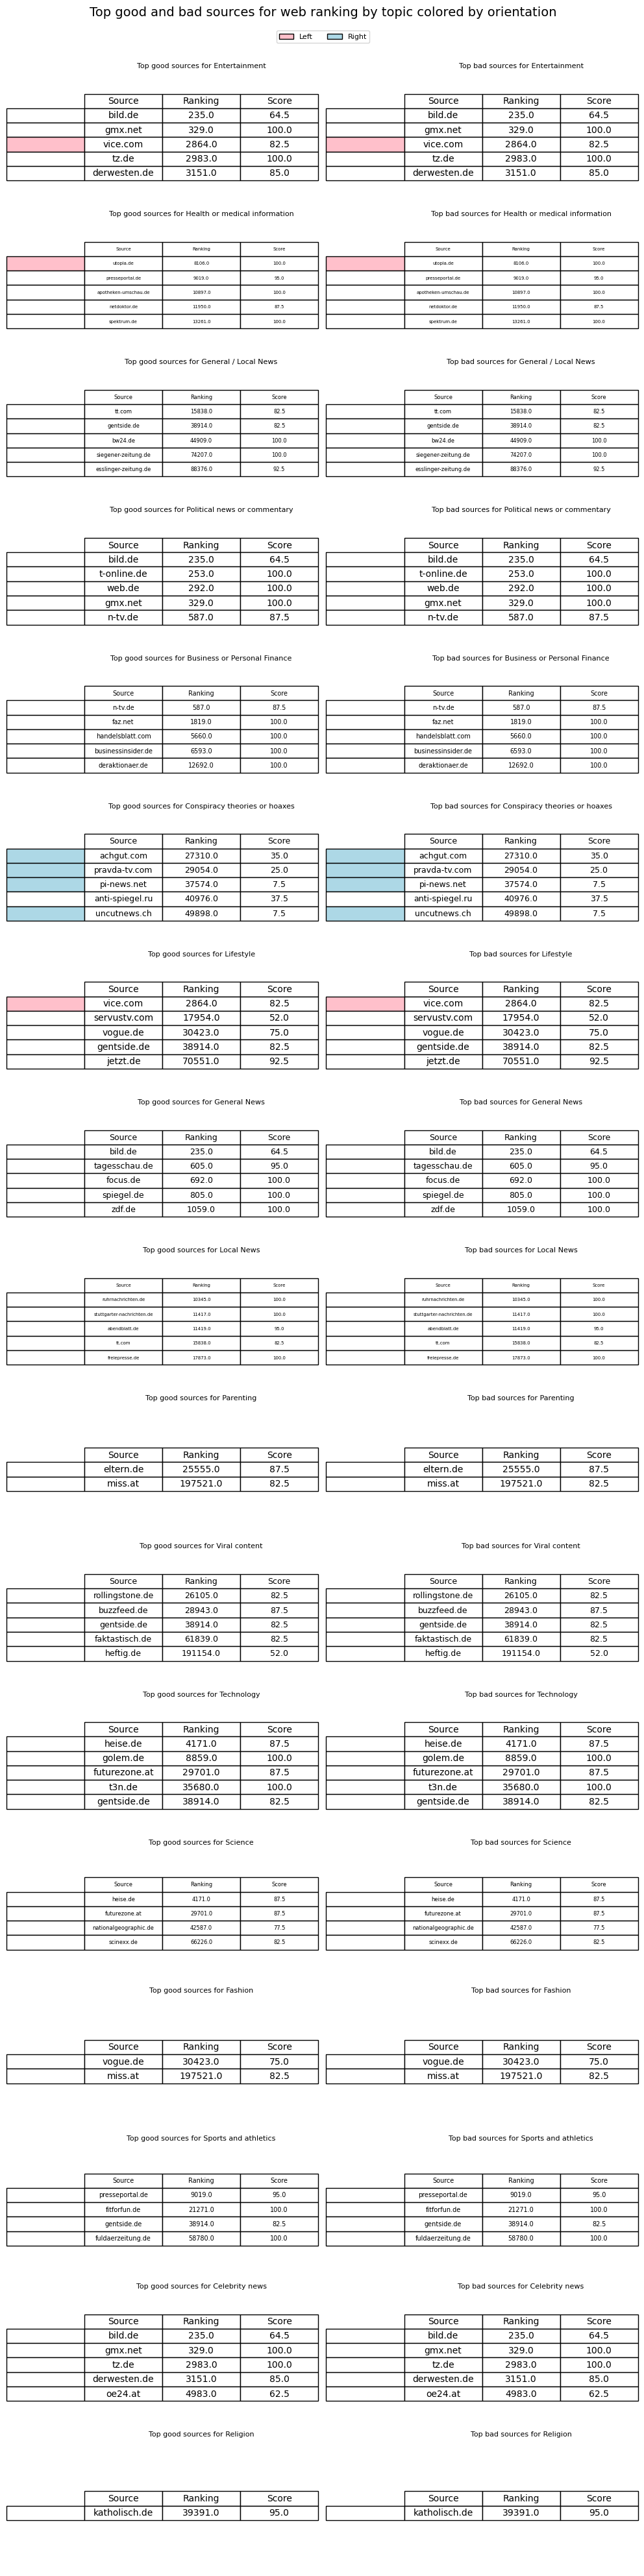

In [73]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
#import patch
from matplotlib.patches import Patch

# make a faced table plot of top goood and bad sources by similar_ranking by topic colored by orientation
fig = plt.figure(figsize=(10, 80))
gs = gridspec.GridSpec(nrows=35, ncols=2, figure=fig)
newi=0
for ie, topic in enumerate(topics):
    # df of rows where topic is in the list of topics
    df_topic = source_df[source_df["Topics"].apply(lambda x: topic in x)]
    
    # make a table of top 5 good and bad sources by similar_ranking
    df_topic_good = df_topic.sort_values(by="Ranking",ascending=True).head(5)
    df_topic_good.Orientation=df_topic_good.Orientation.apply(str)
    
    # plot a table, color by orientation
    colors = [(255/255, 255/255, 255/255, 1) for i in range(len(df_topic_good))]
    for i in range(len(df_topic_good)):
        if df_topic_good.iloc[i]['Orientation'] == 'Left':
            colors[i] = (255/255, 192/255, 203/255, 1)
        elif df_topic_good.iloc[i]['Orientation'] == 'Right':
            colors[i] = (173/255, 216/255, 230/255, 1)
    
    ax1 = fig.add_subplot(gs[newi])
    ax1.table(cellText=df_topic_good[["Source","Ranking","Score"]].values, colLabels=["Source","Ranking","Score"], loc='center',cellLoc='center',rowColours=colors)
    ax1.axis('off')
    ax1.set_title(f"Top good sources for {topic}",fontsize=8)
    
    df_topic_bad = df_topic.sort_values(by="Ranking",ascending=True).head(5)
    df_topic_bad.Orientation=df_topic_bad.Orientation.apply(str)
    
    colors = [(255/255, 255/255, 255/255, 1) for i in range(len(df_topic_bad))]
    for i in range(len(df_topic_bad)):
        if df_topic_bad.iloc[i]['Orientation'] == 'Left':
            colors[i] = (255/255, 192/255, 203/255, 1)
        elif df_topic_bad.iloc[i]['Orientation'] == 'Right':
            colors[i] = (173/255, 216/255, 230/255, 1)
    
    ax2 = fig.add_subplot(gs[newi+1])
    ax2.table(cellText=df_topic_bad[["Source","Ranking","Score"]].values, colLabels=["Source","Ranking","Score"], loc='center',cellLoc='center',rowColours=colors)
    ax2.axis('off')
    ax2.set_title(f"Top bad sources for {topic}",fontsize=8)
    newi=newi+2
    ax1.margins(y=0.1,x=0.1)
    ax2.margins(y=0.1,x=0.1)
    
    # squeeze the table to not fill all the subplot space
    ax1.set_xmargin(1.1)

fig.tight_layout()
# set title
fig.suptitle("Top good and bad sources for web ranking by topic colored by orientation", fontsize=14, position=(0.5,1.009))
legend_elements = [Patch(facecolor=(255/255, 192/255, 203/255, 1), edgecolor='black', label='Left'),Patch(facecolor=(173/255, 216/255, 230/255, 1), edgecolor='black', label='Right')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 1.005))
plt.show()


Apparently, some of the top sources for most topics do not have an orientation score in the dataset

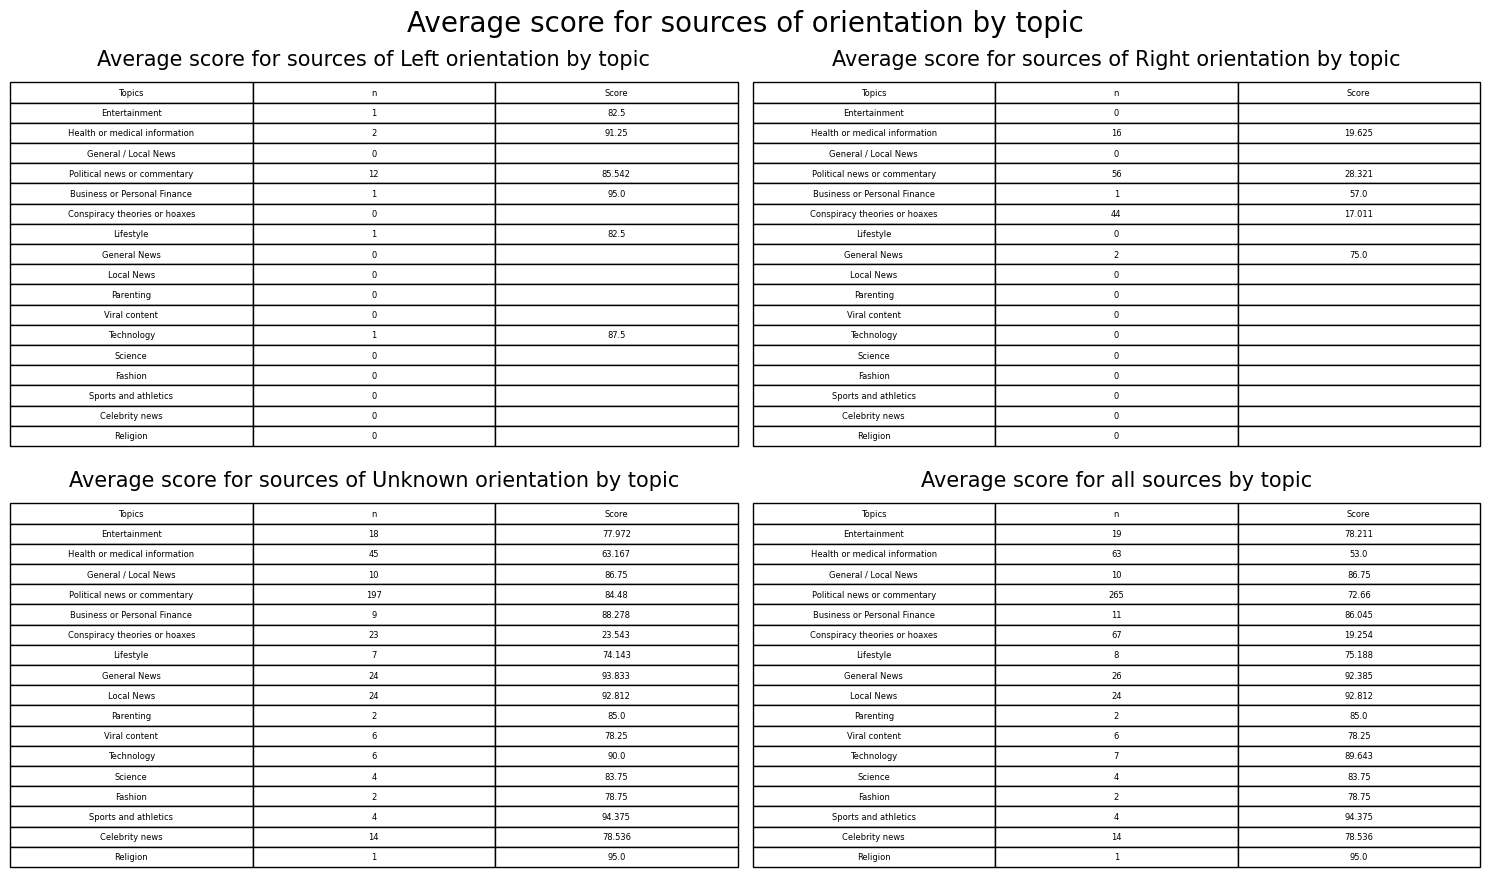

In [74]:
# table with averages of scores by orientation and topic
fig, axs = plt.subplots(2,2,figsize=(15, 9))

#substitutee nan with unknown
source_df = source_df[["Orientation","Score","Topics"]].fillna("Unknown")
for orientation in source_df.Orientation.unique():
    orientation_df = source_df[source_df["Orientation"]==orientation]
    # get ax
    ax= axs[0,0] if orientation=="Left" else axs[0,1] if orientation=="Right" else axs[1,0] if orientation=="Unknown" else axs[1,1]
    df = pd.DataFrame(columns=["Topics","n","Score"])
    for topic in topics:
        orientation_topic_df = orientation_df[orientation_df["Topics"].apply(lambda x: topic in x)]
        mean_score = orientation_topic_df["Score"].mean()
        mean_score = round(mean_score,3) if not np.isnan(mean_score) else ""
        n=len(orientation_topic_df)
        df= pd.concat([df,pd.DataFrame([[topic,n,mean_score]],columns=["Topics","n","Score"])])
    ax.table(cellText=df.values, colLabels=["Topics","n","Score"], loc='center',cellLoc='center')
    ax.title.set_text(f"Average score for sources of {orientation} orientation by topic")
    # turn off axis
    ax.axis('off')
    # reduce margins
    ax.margins(y=0.1,x=0.1)
    ax.title.set_fontsize(15)
ax= axs[1,1]
df= pd.DataFrame(columns=["Topics","n","Score"])
for topic in topics:
    topics_df = source_df[source_df["Topics"].apply(lambda x: topic in x)]
    mean_score = topics_df["Score"].mean()
    mean_score = round(mean_score,3) if not np.isnan(mean_score) else ""
    n=len(topics_df)
    df= pd.concat([df,pd.DataFrame([[topic,n,mean_score]],columns=["Topics","n","Score"])])
    
ax.title.set_text(f"Average score for all sources by topic")
# turn off axis
ax.axis('off')
# reduce margins
ax.margins(y=0.4,x=0.1)
ax.title.set_fontsize(15)
ax.table(cellText=df.values, colLabels=["Topics","n","Score"], loc='center',cellLoc='center')
fig.suptitle("Average score for sources of orientation by topic", fontsize=20)
fig.tight_layout()
    

        

## Checking other languages

In [75]:
df_total_last=df_total[df_total["file_date"]==df_total["file_date"].max()]

df_total_last

UUID                 Domain   
0     4bcfdfb8-5587-4b00-a7c4-c4d46d31bc3a                 al.com  \
1     c6f74984-caa8-4d25-b0ab-dcd42d60d077         jacobinmag.com   
2     a24182b5-9944-43bc-917f-18db87d2f129            jacobin.com   
3     4e2555e2-2abf-4635-ba5c-8c42a706fa9d       bizpacreview.com   
4     e67b8cbe-7ca6-4d0f-b12d-ba25af9b726b   americanwirenews.com   
...                                    ...                    ...   
9921  5b442eb2-eb14-4cf0-b6ff-c81679685b0f  gesundheitstrends.com   
9922  40fb1140-536a-47a0-a06c-023fbc3ddc07          flinkfeed.com   
9923  ae8b500d-683f-4e3d-a4a2-260b725ae142          flinkfeed.com   
9924  38ffb203-ebe5-4cac-8b5a-f84dd3697faf    blog.halle-leaks.de   
9925  954dfb48-6052-4e16-baaf-3f12dfb2ccce    blog.halle-leaks.de   

     Parent Domain Rating  Score   Last Updated Country Language   
0              NaN      T   95.0  1677645622005      US       en  \
1      jacobin.com      T   92.5  1677642090547      US       en   
2      jacobin.com      T   92.5  1677642090426      US       en   
3              NaN      T   62.0  1677641633936      US       en   
4              NaN      T   74.5  1677641172988      US       en   
...            ...    ...    ...            ...     ...      ...   
9921           NaN      T   82.5  1616835161457      DE       de   
9922           NaN      N   39.5  1615380820284     ALL       en   
9923           NaN      N   39.5  1615380816262      DE       de   
9924           NaN      N   37.5  1611208307207      DE       de   
9925           NaN      N   37.5  1611208302785     ALL       en   

     Does not repeatedly publish false content   
0                                          Yes  \
1                                          Yes   
2                                          Yes   
3                                          Yes   
4                                          Yes   
...                                        ...   
9921                                       Yes   
9922                                       Yes   
9923                                       Yes   
9924                                        No   
9925                                        No   

     Gathers and presents information responsibly  ... myths   
0                                             Yes  ...   NaN  \
1                                             Yes  ...   NaN   
2                                             Yes  ...   NaN   
3                                              No  ...   NaN   
4                                              No  ...   NaN   
...                                           ...  ...   ...   
9921                                          Yes  ...   NaN   
9922                                           No  ...   NaN   
9923                                           No  ...   NaN   
9924                                           No  ...   NaN   
9925                                           No  ...   NaN   

                                               iOS App   
0     https://apps.apple.com/us/app/al-com/id419876008  \
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
...                                                ...   
9921                                               NaN   
9922                                               NaN   
9923                                               NaN   
9924                                               NaN   
9925                                               NaN   

                                            Android App Original Reporting   
0     https://play.google.com/store/apps/details?id=...                Yes  \
1                                                   NaN                Yes   
2                                                   NaN                Yes   
3            

In [76]:
df_total_last.shape

(9926, 55)

In [77]:
for language in df_total_last.Language.unique():
    # print average score by language
    unique_sources = df_total_last[df_total_last["Language"]==language]["Domain"].unique()
    print(f"Language: {language}, Average: {df_total_last[df_total_last['Language']==language]['Score'].mean()}, Number of sources: {unique_sources.shape[0]}")

Language: en, Average: 63.592234141791046, Number of sources: 8663
Language: it, Average: 71.71670190274841, Number of sources: 481
Language: fr, Average: 66.00477326968974, Number of sources: 431
Language: de, Average: 75.1125730994152, Number of sources: 347
Language: es, Average: 82.5, Number of sources: 1


## DE, IT and EN dataset

In [78]:
# get it language, de language and en language sources
dataset=df_total[df_total_last["Language"].isin(["it","de","en"])]
dataset=dataset[dataset.Country.isin(["US","IT","DE","GB","AT"])]



C:\Users\rmlaz\AppData\Local\Temp\ipykernel_17472\1609805973.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset=df_total[df_total_last["Language"].isin(["it","de","en"])]


In [79]:
# score over years
dataset["file_date"]=pd.to_datetime(dataset["file_date"])

In [80]:
dataset.groupby(["file_date"]).Score.mean()
dataset.groupby(["file_date"]).Score.median()


file_date
2019-03-01    87.5
2019-09-01    87.5
2020-03-01    82.5
2020-09-01    77.5
2021-03-01    80.0
2021-09-01    77.5
2022-03-01    80.0
2022-09-01    80.0
2023-03-01    72.5
Name: Score, dtype: float64

In [81]:
df_total_last[~df_total_last["Language"].isin(["it","de","en"])].Language.value_counts()

Language
fr    431
es      1
Name: count, dtype: int64

In [82]:
dataset.Language.value_counts()

Language
en    43130
it     2616
de     2027
es        2
Name: count, dtype: int64

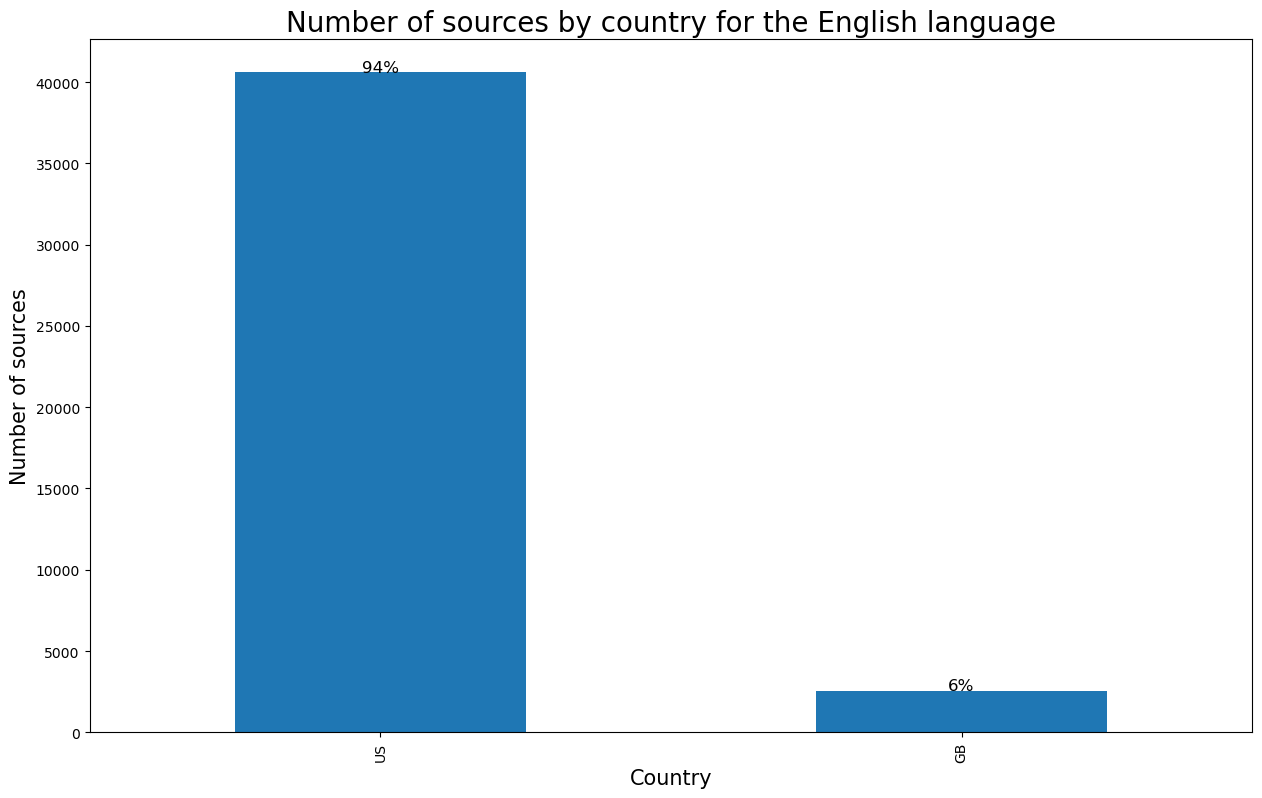

In [83]:
# plot en language sources by country

# bar plot with number of sources by country

plt.figure(figsize=(15, 9))
dataset[dataset["Language"]=="en"].Country.value_counts().plot(kind="bar")
# plot over every bar the percentage of sources

for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x()+p.get_width()/2,height+50, '{:.0f}%'.format(height/dataset[dataset["Language"]=="en"].shape[0]*100), ha="center",fontsize=12)
    


plt.title("Number of sources by country for the English language",fontsize=20)
plt.xlabel("Country",fontsize=15)
plt.ylabel("Number of sources",fontsize=15)
plt.show()

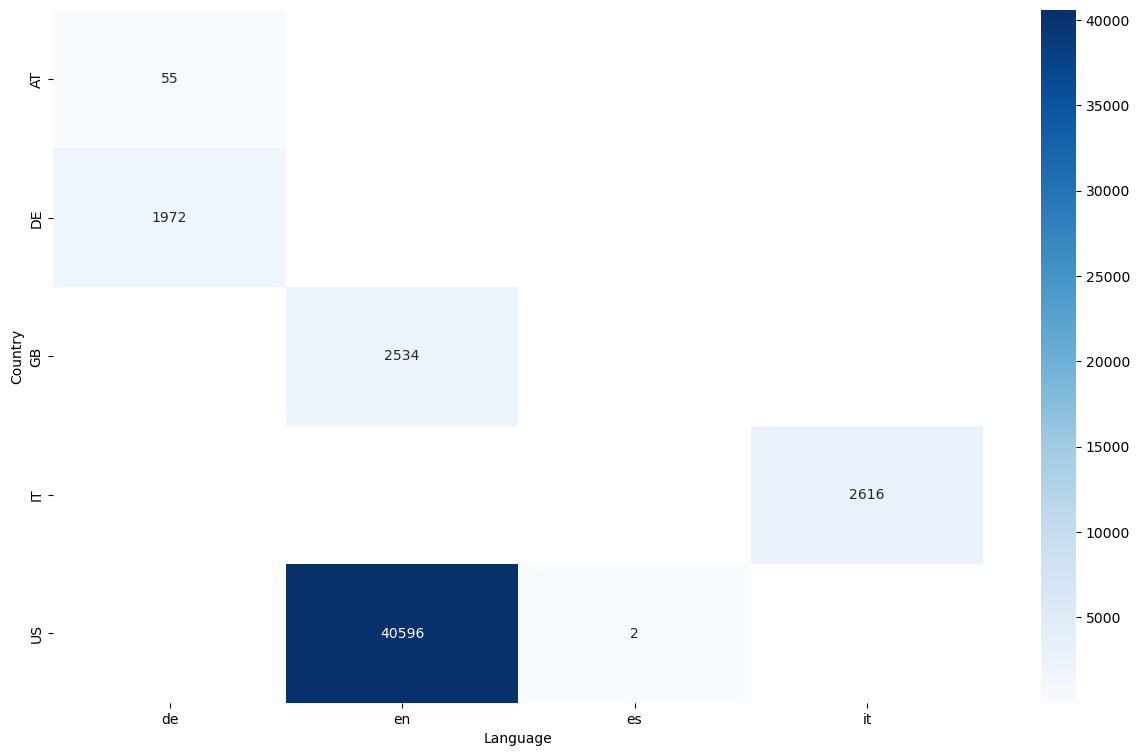

In [84]:
# heatmap with number of sources by country and language

plt.figure(figsize=(15, 9))
sns.heatmap(dataset.groupby(["Country","Language"]).size().unstack(),annot=True,fmt=".0f",cmap="Blues")
plt.show()


In [85]:
# percentage of sources with score over 60 over time rounded to 2 decimals over time
dataset.groupby(["file_date"]).Score.apply(lambda x: x.apply(lambda x: 1 if x>=60 else 0).mean()).round(3)

file_date
2019-03-01    0.714
2019-09-01    0.722
2020-03-01    0.658
2020-09-01    0.553
2021-03-01    0.576
2021-09-01    0.579
2022-03-01    0.607
2022-09-01    0.584
2023-03-01    0.577
Name: Score, dtype: float64

In [86]:

# latest ita sources
ita=dataset[dataset["Language"]=="it"]
ita=ita[ita["file_date"]==ita["file_date"].max()]

In [87]:
ita.columns

Index(['UUID', 'Domain', 'Parent Domain', 'Rating', 'Score', 'Last Updated',
       'Country', 'Language', 'Does not repeatedly publish false content',
       'Gathers and presents information responsibly',
       'Regularly corrects or clarifies errors',
       'Handles the difference between news and opinion responsibly',
       'Avoids deceptive headlines',
       'Website discloses ownership and financing',
       'Clearly labels advertising',
       'Reveals who's in charge, including any possible conflicts of interest',
       'The site provides names of content creators, along with either contact or biographical information',
       'Brand Name', 'Wikipedia', 'Type of Content', 'Medium',
       'Print Publications', 'Scope of Coverage', 'Designated Market Area',
       'Paywall', 'Opinion/Advocacy Journalism', 'Orientation', 'Owner',
       'Type of Owner', 'Facebook', 'Twitter', 'YouTube', 'Instagram',
       'Snapchat', 'LinkedIn', 'Pinterest', 'Main Point of Contact (name)',


In [88]:
# keep only Score, Orientation, Domain and criterias (the long name ones) column
ita=ita[["Score","Orientation","Domain",'Does not repeatedly publish false content',
       'Gathers and presents information responsibly',
       'Regularly corrects or clarifies errors',
       'Handles the difference between news and opinion responsibly',
       'Avoids deceptive headlines',
       'Website discloses ownership and financing',
       'Clearly labels advertising',
       "Reveals who's in charge, including any possible conflicts of interest",
       'The site provides names of content creators, along with either contact or biographical information', "Last Updated"]].sort_values(by="Score",ascending=False)


In [89]:
ita.Score.mean()

71.71670190274841

In [90]:
ita.index=ita.Domain
ita.drop(columns=["Domain"],inplace=True)

<AxesSubplot:ylabel='Frequency'>

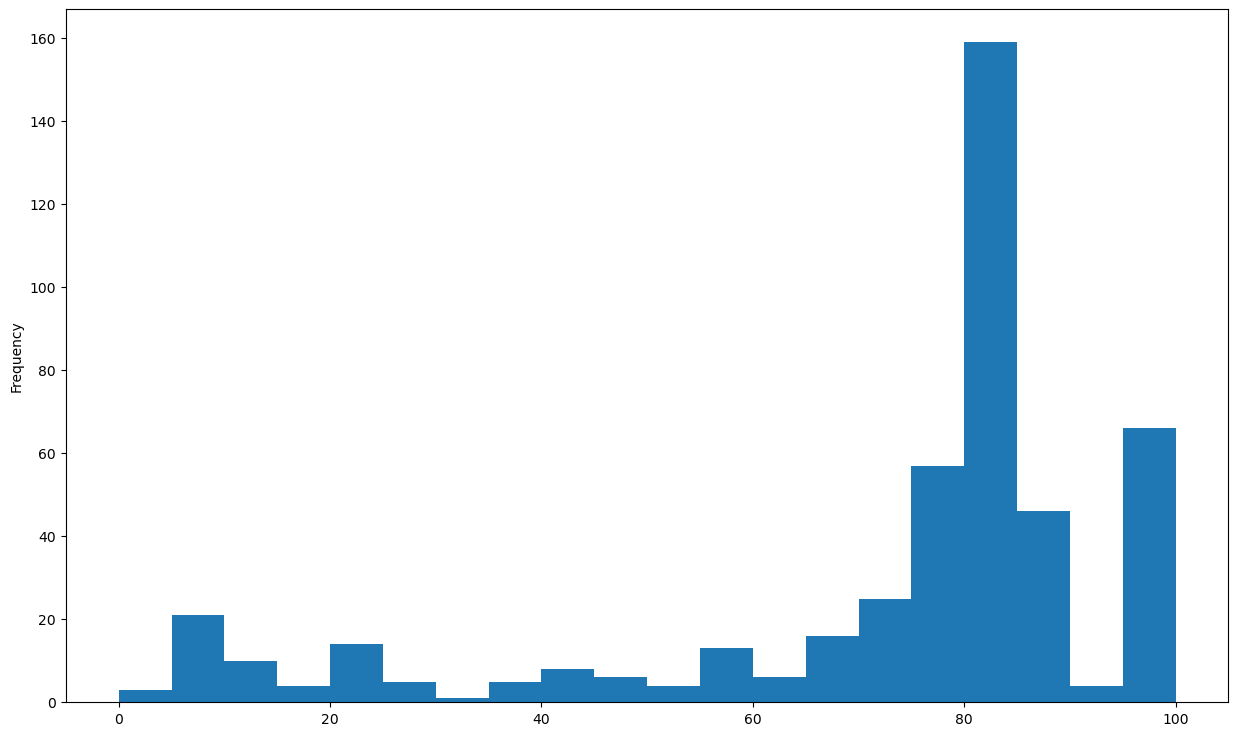

In [91]:
ita.Score.plot(kind="hist",figsize=(15, 9),bins=20)

In [92]:
ita=ita.dropna(subset=["Score"])
# last updated to datetime, unix timestamp
ita["Last Updated"]=pd.to_datetime(ita["Last Updated"],unit="ms")

In [93]:
# sort by last updated
ita=ita.sort_values(by="Last Updated",ascending=False)
ita

Score Orientation   
Domain                                   
visionetv.it          12.5         NaN  \
quicosenza.it         75.0         NaN   
askanews.it           82.5         NaN   
grottaglieinrete.it   82.5         NaN   
gay.it                75.0        Left   
...                    ...         ...   
veronasera.it         82.5         NaN   
parmatoday.it         82.5         NaN   
ilpiacenza.it         82.5         NaN   
livornotoday.it       82.5         NaN   
cisiamo.info          44.5         NaN   

                    Does not repeatedly publish false content   
Domain                                                          
visionetv.it                                               No  \
quicosenza.it                                             Yes   
askanews.it                                               Yes   
grottaglieinrete.it                                       Yes   
gay.it                                                    Yes   
...                                                       ...   
veronasera.it                                             Yes   
parmatoday.it                                             Yes   
ilpiacenza.it                                             Yes   
livornotoday.it                                           Yes   
cisiamo.info                                              Yes   

                    Gathers and presents information responsibly   
Domain                                                             
visionetv.it                                                  No  \
quicosenza.it                                                Yes   
askanews.it                                                  Yes   
grottaglieinrete.it                                          Yes   
gay.it                                                       Yes   
...                                                          ...   
veronasera.it                                                Yes   
parmatoday.it                                                Yes   
ilpiacenza.it                                                Yes   
livornotoday.it                                              Yes   
cisiamo.info                                                  No   

                    Regularly corrects or clarifies errors   
Domain                                                       
visionetv.it                                            No  \
quicosenza.it                                           No   
askanews.it                                             No   
grottaglieinrete.it                                     No   
gay.it                                                  No   
...                                                    ...   
veronasera.it                                           No   
parmatoday.it                                           No   
ilpiacenza.it                                           No   
livornotoday.it                                         No   
cisiamo.info                                            No   

                    Handles the difference between news and opinion responsibly   
Domain                                                                            
visionetv.it                                                        No           \
quicosenza.it                                                      Yes            
askanews.it                                                        Yes            
grottaglieinrete.it                                                Yes            
gay.it                                                              No            
...                                                                ...            
veronasera.it                                                      Yes            
parmatoday.it                                                      Yes            
ilpiacenza.it                                                      Yes            
livornotoday.it        

In [94]:
# find newspapers with scomodo in their domain
ita[ita.index.str.contains("leggi")]

Score Orientation Does not repeatedly publish false content   
Domain                                                                     
leggilo.org   70.0       Right                                       Yes  \

            Gathers and presents information responsibly   
Domain                                                     
leggilo.org                                          Yes  \

            Regularly corrects or clarifies errors   
Domain                                               
leggilo.org                                     No  \

            Handles the difference between news and opinion responsibly   
Domain                                                                    
leggilo.org                                                 No           \

            Avoids deceptive headlines   
Domain                                   
leggilo.org                        Yes  \

            Website discloses ownership and financing   
Domain                                                  
leggilo.org                                       Yes  \

            Clearly labels advertising   
Domain                                   
leggilo.org                        Yes  \

            Reveals who's in charge, including any possible conflicts of interest   
Domain                                                                              
leggilo.org                                                Yes                     \

            The site provides names of content creators, along with either contact or biographical information   
Domain                                                                                                           
leggilo.org                                                 No                                                  \

                       Last Updated  
Domain                               
leggilo.org 2022-07-03 14:36:31.312